In [1]:
"""from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Nlp.version1/')"""

"from google.colab import drive\ndrive.mount('/content/drive')\nimport sys\nsys.path.append('/content/drive/MyDrive/Nlp.version1/')"

In [2]:
"""# CatBoost kütüphanesini yüklemek için
!pip install catboost

# XGBoost kütüphanesini yüklemek için
!pip install xgboost

# Imbalanced-learn kütüphanesini yüklemek için (SMOTE, RandomOverSampler, RandomUnderSampler kullanmak için)
!pip install imbalanced-learn

# scikit-learn kütüphanesini yüklemek için
!pip install scikit-learn==1.4.2

!pip install numpy==1.26.4
# Pandas kütüphanesini yüklemek için
!pip install pandas

# Matplotlib kütüphanesini yüklemek için
!pip install matplotlib

# PyTorch kütüphanesini yüklemek için
!pip install torch

!pip  install openpyxl
!pip install imbalanced-learn"""

'# CatBoost kütüphanesini yüklemek için\n!pip install catboost\n\n# XGBoost kütüphanesini yüklemek için\n!pip install xgboost\n\n# Imbalanced-learn kütüphanesini yüklemek için (SMOTE, RandomOverSampler, RandomUnderSampler kullanmak için)\n!pip install imbalanced-learn\n\n# scikit-learn kütüphanesini yüklemek için\n!pip install scikit-learn==1.4.2\n\n!pip install numpy==1.26.4\n# Pandas kütüphanesini yüklemek için\n!pip install pandas\n\n# Matplotlib kütüphanesini yüklemek için\n!pip install matplotlib\n\n# PyTorch kütüphanesini yüklemek için\n!pip install torch\n\n!pip  install openpyxl\n!pip install imbalanced-learn'

In [3]:
import warnings
warnings.filterwarnings('ignore')
import sklearn
print(sklearn.__version__)

import numpy as np
print(np.__version__)

import pandas as pd
print(pd.__version__)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from collections import Counter

import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier

from gensim.models import Word2Vec
import gensim
print(gensim.__version__)

1.4.2
1.26.4
2.2.2
4.3.3


In [4]:
from functions.function import model_training
from functions.dataSampling import makeVector, turkishWord2Vec
from functions.monitoring import print_system_memory_info,clear_memory
from functions.general_graphic_visualization import visualize_data_splits
from functions.plots import plot_conclusion
from functions.ml_model import evaluate_multiple_models

In [5]:
print("It's alive! It's alive! It's alive!")

It's alive! It's alive! It's alive!


In [6]:
clear_memory()
print_system_memory_info()

Cleared memory.
now memory used: 546.55 MB
Total RAM: 33.62 GB
Available RAM: 22.46 GB
Used RAM: 11.16 GB
RAM Usage: 33.2%

An error occurred while retrieving disk usage information:
argument 1 (impossible<bad format char>)
Total GPU Memory: 8.59 GB
Used GPU Memory: 0.24 GB
Free GPU Memory: 8.34 GB


# Load dataset

In [8]:
# Try to load the dataset
try:
    # Load data from an Excel file
    data = pd.read_csv("TrLlama_HateSpeech.csv")
except Exception as e:
    print(f"Dönüştürme sırasında bir hata oluştu: {e}")
    # Fallback: You can load a CSV file if the Excel file isn't available
    # Uncomment the line below if you have a backup CSV file
    # data = pd.read_csv("data_Llama.csv")
    #/content/drive/MyDrive/Nlp.version1/


In [9]:
if data.isnull().values.any():
    print(data.isnull().sum())
    data.dropna(inplace=True)
    print("After drop null value:")
print(data.isnull().sum())

etiket                     55
tweet                       0
corrected_tweet             0
correct_normalize_tweet     0
dtype: int64
After drop null value:
etiket                     0
tweet                      0
corrected_tweet            0
correct_normalize_tweet    0
dtype: int64


In [10]:
# Retain only the relevant columns: 'tweet' and 'etiket'
data = data[["correct_normalize_tweet","etiket"]]
# Separate tweets and labels
tweets = data['correct_normalize_tweet']
labels = data["etiket"]

In [11]:
# Print the label distribution for inspection
print("Label distribution:")
print(labels.value_counts())

Label distribution:
etiket
hiçbiri      7877
nefret       6006
saldırgan    2680
Name: count, dtype: int64


In [12]:
tweets.head(10)

0    avrupa kazasıyla imzalamış bin sözleşmeye göre...
1    avrupa in kafasızda imzaladığı bin sözleşmeye ...
2    kadın koruma diye sığınak lazım insan yapalım ama
3    ülkede oturup türk vatandaş olur türker 800900...
4    müslümanlara problem olan türlerin başka ülked...
5    hristiyan yahudi zaman budist ateist olmak ist...
6    türk vatandaş olarak 800 900 yüzyıl boyunca mü...
7    gün tek 57 müslüman ülke hristiyan aşırı bekli...
8    hali gelen 57 ülkesinin hristiyan acıları bekl...
9    yakın 57 müslüman ülke hristiyan aşırı bekliyo...
Name: correct_normalize_tweet, dtype: object

In [13]:
labels.head(10)

0       nefret
1       nefret
2       nefret
3       nefret
4       nefret
5       nefret
6       nefret
7    saldırgan
8    saldırgan
9    saldırgan
Name: etiket, dtype: object

In [14]:
print("Original data class distribution:", Counter(labels))

Original data class distribution: Counter({'hiçbiri': 7877, 'nefret': 6006, 'saldırgan': 2680})


In [15]:
# Calculate class distribution with Counter
class_distribution = Counter(labels)

# Total number of data points
total_count = sum(class_distribution.values())

# Calculate and display percentage distribution
print("Original data class distribution:")
for label, count in class_distribution.items():
    percentage = (count / total_count) * 100
    print(f"{label}: {count} instances ({percentage:.2f}%)")

Original data class distribution:
nefret: 6006 instances (36.26%)
saldırgan: 2680 instances (16.18%)
hiçbiri: 7877 instances (47.56%)


# 📈 ML - Models ✨--------------------------------------------------------------------------------------

In [17]:
xgb_model = xgb.XGBClassifier(tree_method='gpu_hist',max_depth=6, gpu_id=0, random_state=42, use_label_encoder=False,  n_estimators=50)
catB_model = CatBoostClassifier(iterations=50, learning_rate=0.1, depth=4, verbose=0)# (XGBoost ve CatBoost)
ann_mlpc_sgd = MLPClassifier(solver='sgd', alpha=1e-5, activation='relu',  hidden_layer_sizes=(20, 10, 5),max_iter=50, learning_rate='adaptive', random_state=7)# MLPClassifier (Yapay Sinir Ağı Sınıflandırıcı)
extraTC = ExtraTreesClassifier(n_estimators=100, random_state=7)# ExtraTreesClassifier (Ekstra Karar Ağaçları)

In [18]:
modelsAndNames =   [
    ('CatBoostC', catB_model),
       ('XGBoost', xgb_model),
      
       ('MLPC-sgd', ann_mlpc_sgd),
       ('ExtraTreesC', extraTC),
       
   ]

# Converting categorical labels to numerical data

In [20]:
label_mapping = {'nefret': 1, 'hiçbiri': 0, 'saldırgan': 2}
labels = data['etiket'].map(label_mapping)

#for saving result
result_dic ={}

len_labels = len(set(labels)) #for num_classes

# Splitting the data into training and test sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.2, random_state=42)
dataset_names = ["labels","y_train","y_test"]

In [23]:
print(y_train.value_counts())

etiket
0    6342
1    4778
2    2130
Name: count, dtype: int64


In [24]:
print(y_test.value_counts())

etiket
0    1535
1    1228
2     550
Name: count, dtype: int64


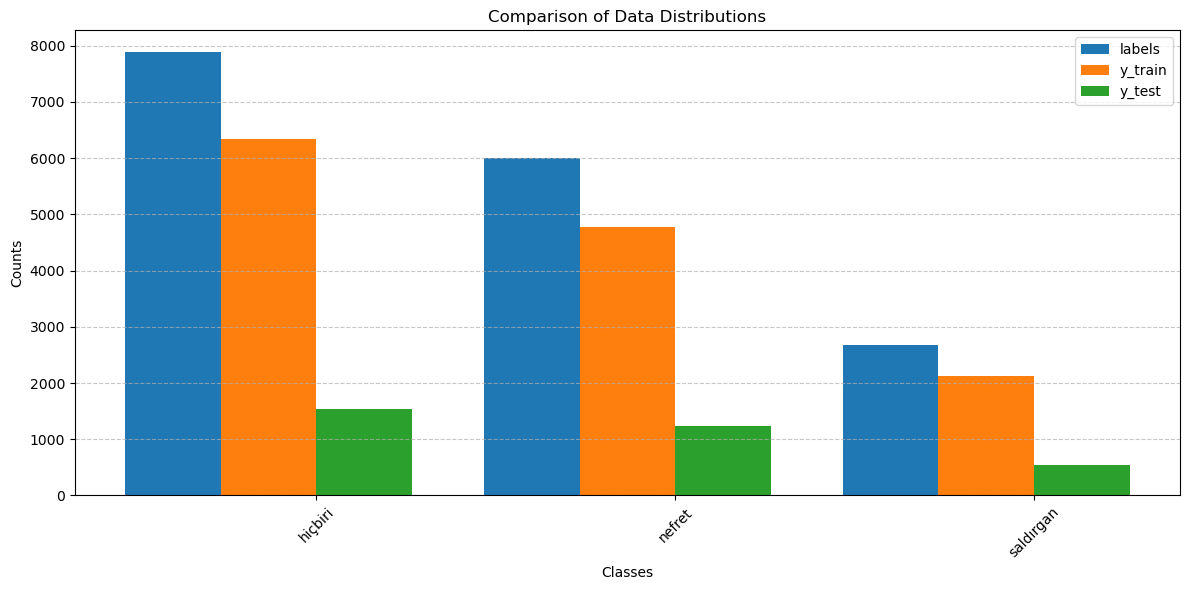

In [25]:
visualize_data_splits(
    labels, y_train, y_test,
    label_mapping=label_mapping
    ,dataset_names=dataset_names
)

# Word2Vec and Fine-Tune Word2Vec

In [27]:
results_df = pd.DataFrame(columns=['Model', 'Vectorization Method', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

## Turkish Word2Vec

In [29]:
X_train_wv,X_test_wv,y_train_wv,y_test_wv = turkishWord2Vec(X_train,X_test,y_train,y_test,model_type ='basic')

Word2Vec conversion is performed for X_train...
Word2Vec conversion is performed for X_test...
X_train_wv shape: (13250, 400)
X_test_wv shape: (3313, 400)
Before sampling Counter({0: 6342, 1: 4778, 2: 2130})
After sampling Counter({0: 6342, 2: 6342, 1: 6342})
x_train_smote shape: (19026, 400), y_train_smote shape: (19026,)


In [30]:
non_zero_count = np.count_nonzero(X_train_wv)

print(f"There are {non_zero_count} non-zero values in the dataset.")
print(f"X_train_wv frist 5 element: {X_train_wv[:5]}")

There are 7605600 non-zero values in the dataset.
X_train_wv frist 5 element: [[ 0.60421532 -0.27123025 -0.5814414  ...  0.33757511 -0.12588251
  -0.77894211]
 [-0.13093282 -0.40713146 -0.39746568 ...  0.23659635 -0.59701782
  -0.50580949]
 [-0.04832881 -0.50483972 -0.5175277  ...  0.07297467  0.33663797
  -0.72368956]
 [ 0.28936502 -0.30477566 -1.11115038 ...  0.27486679 -0.98141843
  -0.50333112]
 [ 0.47985327 -0.72376049 -0.49791721 ...  0.05547435 -0.93442941
  -0.50929743]]


CatBoostError: catboost/libs/data/quantization.cpp:2420: All features are either constant or ignored.
I could not solve this error with normalize or scaler.
The error is caused by the Word2Vec model being loaded correctly but being given the wrong input.


Evaluating CatBoostC...
Model Evaluation: CatBoostC
F1 Score: 0.53144 | Accuracy: 0.52400 | Precision: 0.55640 | Recall: 0.52400 | Training Accuracy: 0.53769 | Validation Accuracy: 0.52400


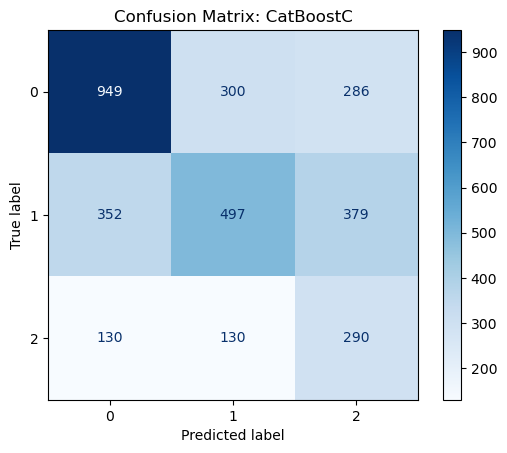

Model saved at: ml_model\ml_CatBoostC_TurkishWord2Vec.joblib

Evaluating XGBoost...
Model Evaluation: XGBoost
F1 Score: 0.78236 | Accuracy: 0.78237 | Precision: 0.78244 | Recall: 0.78237 | Training Accuracy: 0.81851 | Validation Accuracy: 0.78237


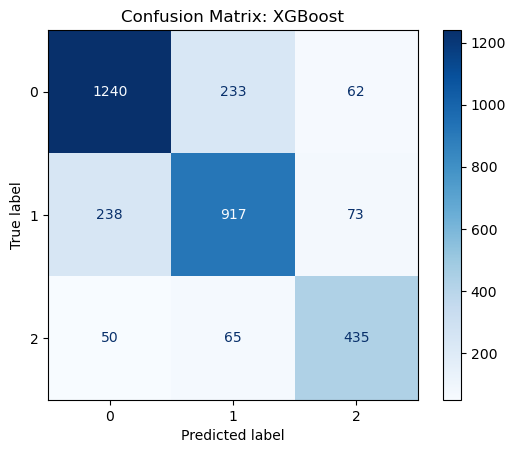

Model saved at: ml_model\ml_XGBoost_TurkishWord2Vec.joblib

Evaluating MLPC-sgd...
Model Evaluation: MLPC-sgd
F1 Score: 0.59582 | Accuracy: 0.59131 | Precision: 0.60742 | Recall: 0.59131 | Training Accuracy: 0.58988 | Validation Accuracy: 0.59131


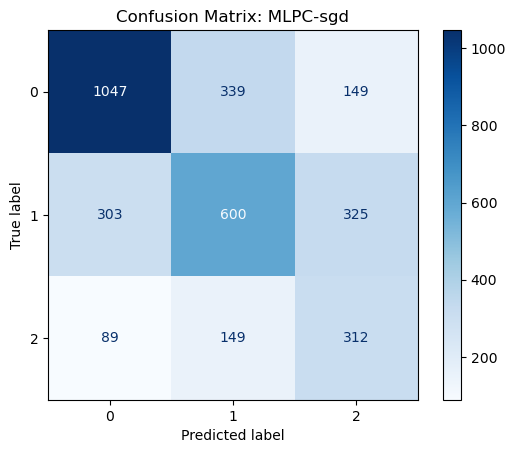

Model saved at: ml_model\ml_MLPC-sgd_TurkishWord2Vec.joblib

Evaluating ExtraTreesC...
Model Evaluation: ExtraTreesC
F1 Score: 0.80063 | Accuracy: 0.80531 | Precision: 0.81755 | Recall: 0.80531 | Training Accuracy: 0.84484 | Validation Accuracy: 0.80531


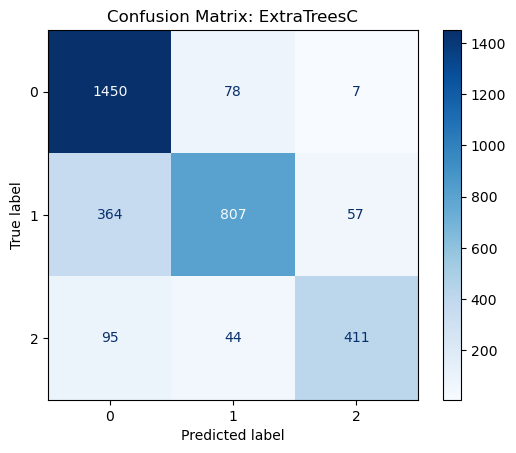

Model saved at: ml_model\ml_ExtraTreesC_TurkishWord2Vec.joblib


In [32]:
df_W2v_ml = evaluate_multiple_models(
    X_train_wv,X_test_wv,
    y_train_wv,y_test_wv,
    modelsAndNames,
    vectorization_method="TurkishWord2Vec"
)

In [33]:
results_df = pd.concat([results_df, df_W2v_ml], ignore_index=True)


TurkishWord2Vec:
Epoch [1/50], Train Loss: 0.8384, Train Accuracy: 0.6994, Validation Loss: 1.3854, Validation Accuracy: 0.1660
Epoch [2/50], Train Loss: 0.8517, Train Accuracy: 0.6906, Validation Loss: 1.3821, Validation Accuracy: 0.1672
Epoch [3/50], Train Loss: 0.8162, Train Accuracy: 0.7256, Validation Loss: 1.3846, Validation Accuracy: 0.1666
Epoch [4/50], Train Loss: 0.8111, Train Accuracy: 0.7323, Validation Loss: 1.3830, Validation Accuracy: 0.1678
Epoch [5/50], Train Loss: 0.7915, Train Accuracy: 0.7545, Validation Loss: 1.3758, Validation Accuracy: 0.1751
Epoch [6/50], Train Loss: 0.7982, Train Accuracy: 0.7489, Validation Loss: 1.3754, Validation Accuracy: 0.1760
Epoch [7/50], Train Loss: 0.7855, Train Accuracy: 0.7627, Validation Loss: 1.3739, Validation Accuracy: 0.1778
Epoch [8/50], Train Loss: 0.7727, Train Accuracy: 0.7749, Validation Loss: 1.3738, Validation Accuracy: 0.1775
Epoch [9/50], Train Loss: 0.7833, Train Accuracy: 0.7645, Validation Loss: 1.3848, Validation 

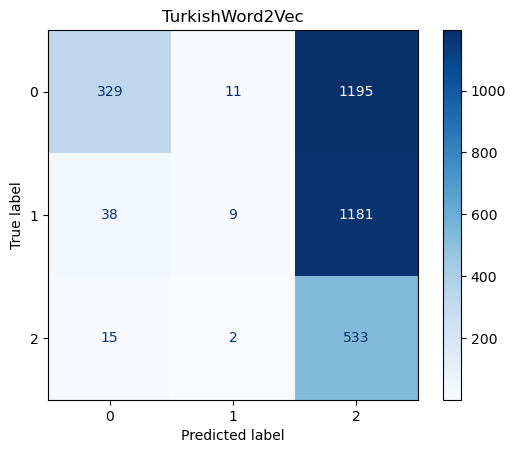

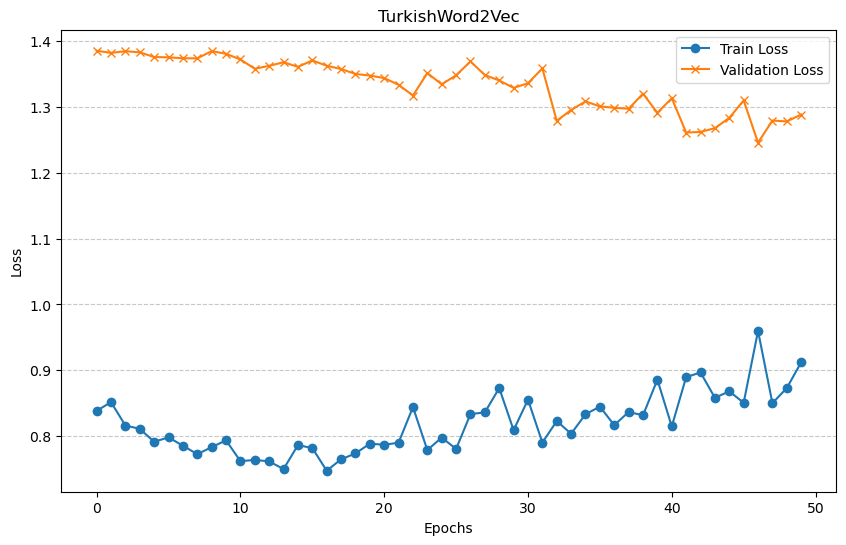

Model saved to models/TurkishWord2Vec_ANN.pth
Results saved to models/TurkishWord2Vec_results.csv


In [34]:
df_W2V = model_training("TurkishWord2Vec",X_train_wv,X_test_wv,y_train_wv,y_test_wv,len_labels)

In [35]:
results_df = pd.concat([results_df, df_W2V], ignore_index=True)

In [36]:
results_df

,Model,Vectorization Method,Accuracy,Precision,Recall,F1 Score
0,CatBoostC,TurkishWord2Vec,0.523996,0.556403,0.523996,0.531438
1,XGBoost,TurkishWord2Vec,0.782372,0.782442,0.782372,0.782356
2,MLPC-sgd,TurkishWord2Vec,0.591307,0.607418,0.591307,0.595820
3,ExtraTreesC,TurkishWord2Vec,0.805312,0.817553,0.805312,0.800627
4,ANN,TurkishWord2Vec,0.262904,0.581094,0.262904,0.215534


## Fine-Tune Turkish Word2Vec

In [38]:
X_train_Ft,X_test_Ft,y_train_Ft,y_test_Ft = turkishWord2Vec(X_train,X_test,y_train,y_test,model_type = 'finetune' )

Word2Vec conversion is performed for X_train...
Word2Vec conversion is performed for X_test...
X_train_wv shape: (13250, 400)
X_test_wv shape: (3313, 400)
Before sampling Counter({0: 6342, 1: 4778, 2: 2130})
After sampling Counter({0: 6342, 2: 6342, 1: 6342})
x_train_smote shape: (19026, 400), y_train_smote shape: (19026,)


In [39]:
non_zero_count = np.count_nonzero(X_train_Ft)

print(f"There are {non_zero_count} non-zero values in the dataset.")

There are 7609200 non-zero values in the dataset.



Evaluating CatBoostC...
Model Evaluation: CatBoostC
F1 Score: 0.51201 | Accuracy: 0.50921 | Precision: 0.52111 | Recall: 0.50921 | Training Accuracy: 0.49427 | Validation Accuracy: 0.50921


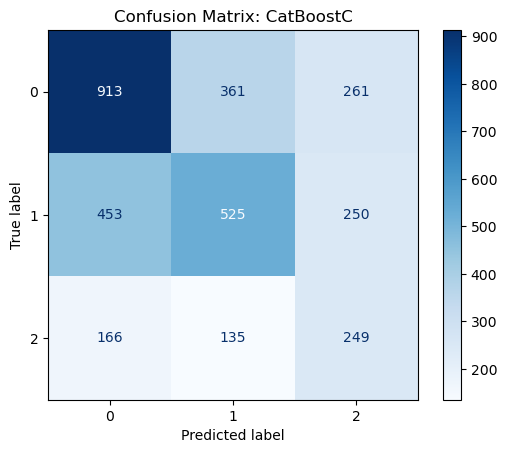

Model saved at: ml_model\ml_CatBoostC_FineTuneWord2Vec.joblib

Evaluating XGBoost...
Model Evaluation: XGBoost
F1 Score: 0.74055 | Accuracy: 0.74042 | Precision: 0.74076 | Recall: 0.74042 | Training Accuracy: 0.77836 | Validation Accuracy: 0.74042


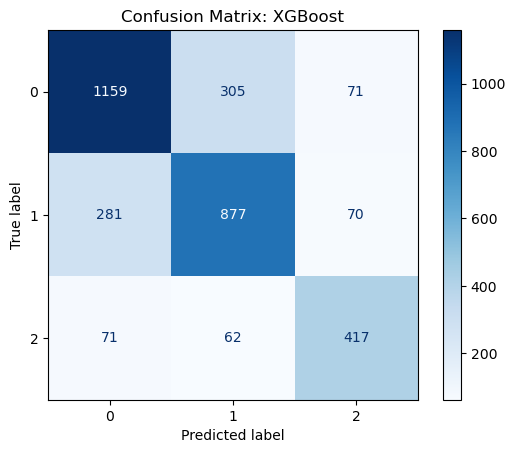

Model saved at: ml_model\ml_XGBoost_FineTuneWord2Vec.joblib

Evaluating MLPC-sgd...
Model Evaluation: MLPC-sgd
F1 Score: 0.37060 | Accuracy: 0.36704 | Precision: 0.44585 | Recall: 0.36704 | Training Accuracy: 0.38579 | Validation Accuracy: 0.36704


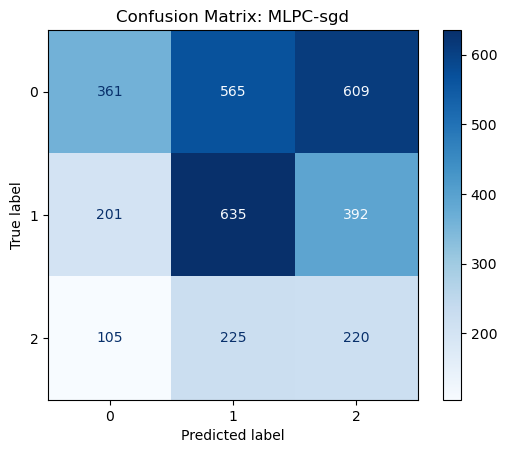

Model saved at: ml_model\ml_MLPC-sgd_FineTuneWord2Vec.joblib

Evaluating ExtraTreesC...
Model Evaluation: ExtraTreesC
F1 Score: 0.78984 | Accuracy: 0.79294 | Precision: 0.80165 | Recall: 0.79294 | Training Accuracy: 0.82209 | Validation Accuracy: 0.79294


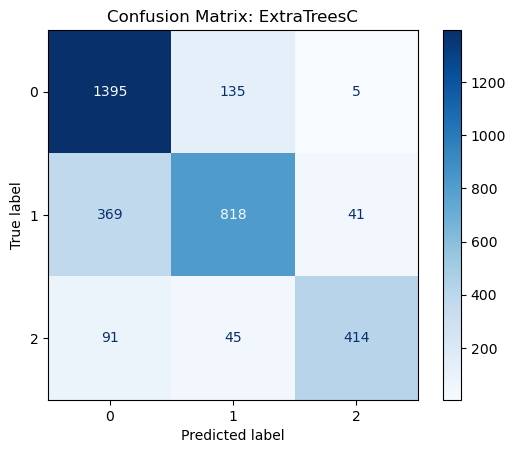

Model saved at: ml_model\ml_ExtraTreesC_FineTuneWord2Vec.joblib


In [40]:
df_W2v_ml = evaluate_multiple_models(
    X_train_Ft,X_test_Ft,y_train_Ft,y_test_Ft,
    modelsAndNames,
    vectorization_method="FineTuneWord2Vec"
)

In [41]:
results_df = pd.concat([results_df, df_W2v_ml], ignore_index=True)


FineTuneWord2Vec:
Epoch [1/50], Train Loss: 0.9376, Train Accuracy: 0.5872, Validation Loss: 1.3854, Validation Accuracy: 0.1660
Epoch [2/50], Train Loss: 0.9472, Train Accuracy: 0.5923, Validation Loss: 1.3852, Validation Accuracy: 0.1663
Epoch [3/50], Train Loss: 0.8951, Train Accuracy: 0.6443, Validation Loss: 1.3856, Validation Accuracy: 0.1657
Epoch [4/50], Train Loss: 0.9233, Train Accuracy: 0.6182, Validation Loss: 1.3847, Validation Accuracy: 0.1666
Epoch [5/50], Train Loss: 0.9129, Train Accuracy: 0.6289, Validation Loss: 1.3847, Validation Accuracy: 0.1666
Epoch [6/50], Train Loss: 0.9421, Train Accuracy: 0.6047, Validation Loss: 1.3837, Validation Accuracy: 0.1675
Epoch [7/50], Train Loss: 0.9444, Train Accuracy: 0.6005, Validation Loss: 1.3836, Validation Accuracy: 0.1678
Epoch [8/50], Train Loss: 0.9470, Train Accuracy: 0.5984, Validation Loss: 1.3830, Validation Accuracy: 0.1684
Epoch [9/50], Train Loss: 0.8816, Train Accuracy: 0.6611, Validation Loss: 1.3838, Validation

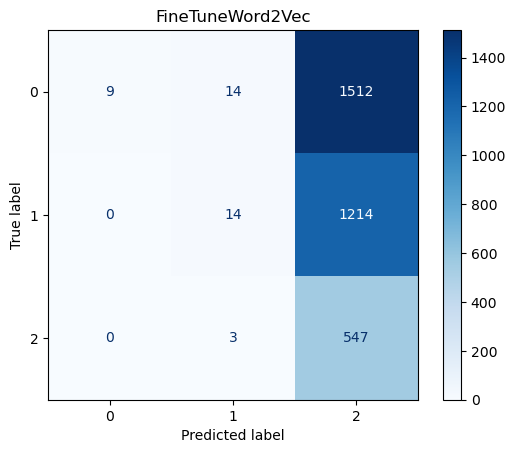

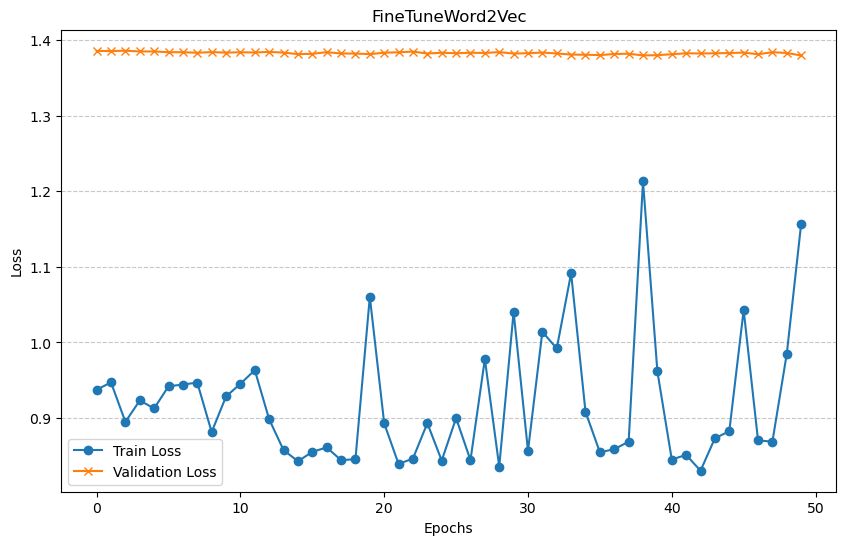

Model saved to models/FineTuneWord2Vec_ANN.pth
Results saved to models/FineTuneWord2Vec_results.csv


In [42]:
df_FTW = model_training(
    "FineTuneWord2Vec",
    X_train_Ft,X_test_Ft,
    y_train_Ft,y_test_Ft,
    len_labels
)

In [43]:
results_df = pd.concat([results_df, df_FTW], ignore_index=True)

In [44]:
results_df

,Model,Vectorization Method,Accuracy,Precision,Recall,F1 Score
0,CatBoostC,TurkishWord2Vec,0.523996,0.556403,0.523996,0.531438
1,XGBoost,TurkishWord2Vec,0.782372,0.782442,0.782372,0.782356
2,MLPC-sgd,TurkishWord2Vec,0.591307,0.607418,0.591307,0.595820
3,ExtraTreesC,TurkishWord2Vec,0.805312,0.817553,0.805312,0.800627
4,ANN,TurkishWord2Vec,0.262904,0.581094,0.262904,0.215534
5,CatBoostC,FineTuneWord2Vec,0.509206,0.521106,0.509206,0.512013
6,XGBoost,FineTuneWord2Vec,0.740417,0.740764,0.740417,0.740551
7,MLPC-sgd,FineTuneWord2Vec,0.367039,0.445850,0.367039,0.370599
8,ExtraTreesC,FineTuneWord2Vec,0.792937,0.801651,0.792937,0.789837
9,ANN,FineTuneWord2Vec,0.172050,0.658466,0.172050,0.061152


# GRAM in CountVectorizer and TfidfVectorizer ------------------------------

In [46]:
#Word unigram and bigram ,Char bigram and trigram

# Word  unigram
word_unigram_count = CountVectorizer(ngram_range=(1, 1) , analyzer='word',max_features=9000)  
word_unigram_tfidf = TfidfVectorizer(ngram_range=(1, 1) ,analyzer='word',max_features=9000)  # Word unigram TF-IDF

# Word bigram
word_bigram_count = CountVectorizer(ngram_range=(2, 2), analyzer='word',max_features=9000)  
word_bigram_tfidf = TfidfVectorizer(ngram_range=(2, 2), analyzer='word',max_features=9000)  # Word bigram TF-IDF

# Char  bigram 
char_bigram_count = CountVectorizer(ngram_range=(2, 2), analyzer='char',max_features=9000)  
char_bigram_tfidf = TfidfVectorizer(ngram_range=(2, 2), analyzer='char',max_features=9000)  # Char bigram TF-IDF

# Char trigram 
char_trigram_count = CountVectorizer(ngram_range=(3, 3), analyzer='char',max_features=9000)  
char_trigram_tfidf = TfidfVectorizer(ngram_range=(3, 3), analyzer='char',max_features=9000)  #Char trigram TF-IDF


# Word Unigram-------------------------------------------

In [48]:
feature_union = FeatureUnion([
    ("word_unigram_count", word_unigram_count),
    ("word_unigram_tfidf", word_unigram_tfidf)
])

In [49]:
X_train_vec,X_test_vec,y_train_vec,y_test_vec = makeVector(feature_union,X_train,X_test,y_train,y_test)

y_train shape: (13250,)
First 10 feature names: ['word_unigram_count__00' 'word_unigram_count__000'
 'word_unigram_count__02' 'word_unigram_count__0332'
 'word_unigram_count__05' 'word_unigram_count__07'
 'word_unigram_count__08' 'word_unigram_count__09'
 'word_unigram_count__10' 'word_unigram_count__100']
X_train_features shape: (13250, 18000)
X_test_features shape: (3313, 18000)
Before sampling Counter({0: 6342, 1: 4778, 2: 2130})
After sampling Counter({0: 6342, 2: 6342, 1: 6342})
X_train shape: (19026, 18000),y_train shape: (19026,),


In [50]:
print(X_test_vec.dtype)

print(X_train_vec.dtype)

print(y_train_vec.dtype)

print(y_test_vec.dtype)

print("NaN in X_train:", np.isnan(X_train_vec).sum())
print("Inf in X_train:", np.isinf(X_train_vec).sum())
print("Feature variances:", np.var(X_train_vec, axis=0))
print(X_train_vec)

float64
float64
int64
int64
NaN in X_train: 0
Inf in X_train: 0
Feature variances: [1.15560521e-03 2.99363139e-03 2.62729213e-04 ... 5.88538222e-05
 1.85811682e-05 2.29020178e-05]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [51]:
non_zero_count = np.count_nonzero(X_train_vec)

print(f"There are {non_zero_count} non-zero values in the dataset.")

There are 524188 non-zero values in the dataset.



Evaluating CatBoostC...
Model Evaluation: CatBoostC
F1 Score: 0.52431 | Accuracy: 0.51947 | Precision: 0.55797 | Recall: 0.51947 | Training Accuracy: 0.54609 | Validation Accuracy: 0.51947


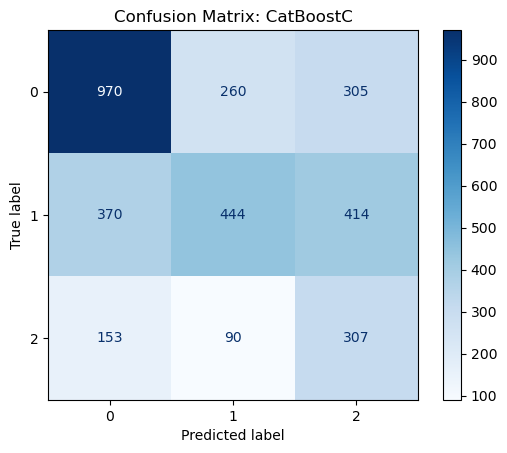

Model saved at: ml_model\ml_CatBoostC_WordUnigram.joblib

Evaluating XGBoost...
Model Evaluation: XGBoost
F1 Score: 0.67347 | Accuracy: 0.67250 | Precision: 0.67565 | Recall: 0.67250 | Training Accuracy: 0.69295 | Validation Accuracy: 0.67250


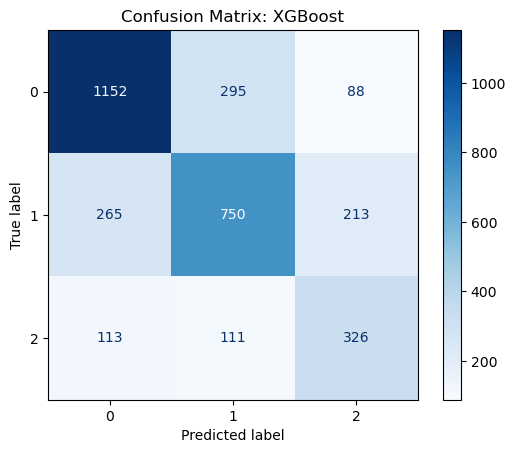

Model saved at: ml_model\ml_XGBoost_WordUnigram.joblib

Evaluating MLPC-sgd...
Model Evaluation: MLPC-sgd
F1 Score: 0.78440 | Accuracy: 0.78328 | Precision: 0.78780 | Recall: 0.78328 | Training Accuracy: 0.77683 | Validation Accuracy: 0.78328


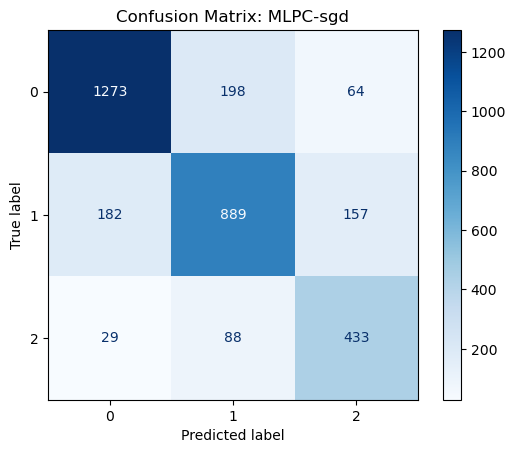

Model saved at: ml_model\ml_MLPC-sgd_WordUnigram.joblib

Evaluating ExtraTreesC...
Model Evaluation: ExtraTreesC
F1 Score: 0.84127 | Accuracy: 0.84425 | Precision: 0.84912 | Recall: 0.84425 | Training Accuracy: 0.87491 | Validation Accuracy: 0.84425


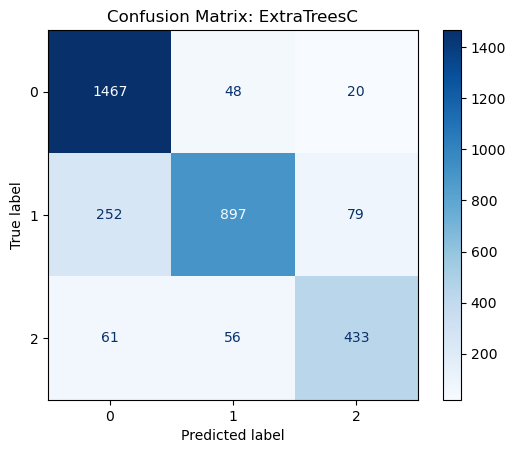

Model saved at: ml_model\ml_ExtraTreesC_WordUnigram.joblib


In [52]:
df_WU_ml = evaluate_multiple_models(
    X_train_vec,X_test_vec,y_train_vec,y_test_vec,
    modelsAndNames,
    vectorization_method="WordUnigram"
)

In [53]:
results_df = pd.concat([results_df, df_WU_ml], ignore_index=True)


WordUnigram:
Epoch [1/50], Train Loss: 0.7831, Train Accuracy: 0.7653, Validation Loss: 1.3854, Validation Accuracy: 0.1660
Epoch [2/50], Train Loss: 0.6841, Train Accuracy: 0.8654, Validation Loss: 1.3829, Validation Accuracy: 0.1669
Epoch [3/50], Train Loss: 0.6299, Train Accuracy: 0.9203, Validation Loss: 1.3088, Validation Accuracy: 0.2333
Epoch [4/50], Train Loss: 0.6068, Train Accuracy: 0.9438, Validation Loss: 1.3731, Validation Accuracy: 0.1757
Epoch [5/50], Train Loss: 0.5955, Train Accuracy: 0.9553, Validation Loss: 1.1594, Validation Accuracy: 0.3794
Epoch [6/50], Train Loss: 0.5860, Train Accuracy: 0.9653, Validation Loss: 1.3422, Validation Accuracy: 0.1995
Epoch [7/50], Train Loss: 0.5816, Train Accuracy: 0.9695, Validation Loss: 1.1119, Validation Accuracy: 0.4289
Epoch [8/50], Train Loss: 0.5785, Train Accuracy: 0.9729, Validation Loss: 1.0308, Validation Accuracy: 0.5089
Epoch [9/50], Train Loss: 0.5762, Train Accuracy: 0.9750, Validation Loss: 1.0688, Validation Accu

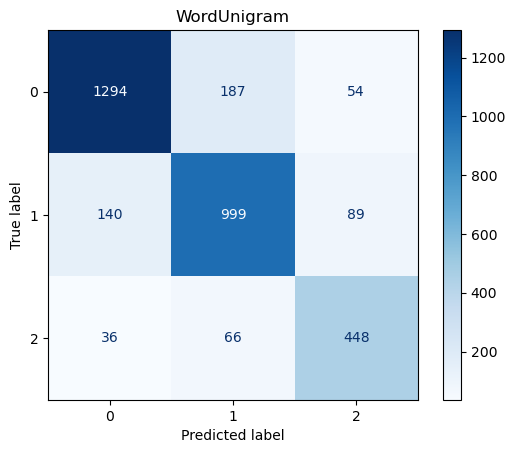

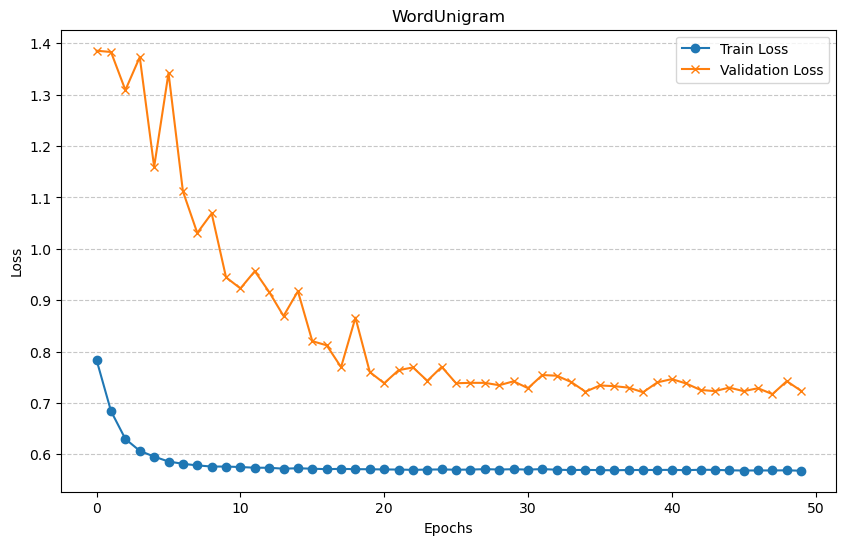

Model saved to models/WordUnigram_ANN.pth
Results saved to models/WordUnigram_results.csv
Model training completed successfully.
Model metric saved


In [54]:
try:
    df_WU = model_training("WordUnigram", X_train_vec, X_test_vec, y_train_vec, y_test_vec,len_labels)

except Exception as e:
    print("An error occurred during model training:")
    print(e)
    clear_memory()

else:
    print("Model training completed successfully.")
    results_df = pd.concat([results_df, df_WU], ignore_index=True)
    print("Model metric saved")

In [55]:
results_df

,Model,Vectorization Method,Accuracy,Precision,Recall,F1 Score
0,CatBoostC,TurkishWord2Vec,0.523996,0.556403,0.523996,0.531438
1,XGBoost,TurkishWord2Vec,0.782372,0.782442,0.782372,0.782356
2,MLPC-sgd,TurkishWord2Vec,0.591307,0.607418,0.591307,0.595820
3,ExtraTreesC,TurkishWord2Vec,0.805312,0.817553,0.805312,0.800627
4,ANN,TurkishWord2Vec,0.262904,0.581094,0.262904,0.215534
5,CatBoostC,FineTuneWord2Vec,0.509206,0.521106,0.509206,0.512013
6,XGBoost,FineTuneWord2Vec,0.740417,0.740764,0.740417,0.740551
7,MLPC-sgd,FineTuneWord2Vec,0.367039,0.445850,0.367039,0.370599
8,ExtraTreesC,FineTuneWord2Vec,0.792937,0.801651,0.792937,0.789837
9,ANN,FineTuneWord2Vec,0.172050,0.658466,0.172050,0.061152


In [56]:
clear_memory()

Cleared memory.
now memory used: 4686.99 MB


# Word Bigram-------------------------------------------

In [58]:
feature_union = FeatureUnion([
    ("word_bigram_count", word_bigram_count),
    ("word_bigram_tfidf", word_bigram_tfidf)
])

In [59]:
X_train_vec,X_test_vec,y_train_vec,y_test_vec = makeVector(feature_union,X_train,X_test,y_train,y_test)

y_train shape: (13250,)
First 10 feature names: ['word_bigram_count__000 000' 'word_bigram_count__07 anafartalar'
 'word_bigram_count__08 güngören' 'word_bigram_count__10 bin'
 'word_bigram_count__10 gün' 'word_bigram_count__10 kasım'
 'word_bigram_count__10 milyon' 'word_bigram_count__10 sığınmacının'
 'word_bigram_count__10 yıl' 'word_bigram_count__10 yılda']
X_train_features shape: (13250, 18000)
X_test_features shape: (3313, 18000)
Before sampling Counter({0: 6342, 1: 4778, 2: 2130})
After sampling Counter({0: 6342, 2: 6342, 1: 6342})
X_train shape: (19026, 18000),y_train shape: (19026,),



Evaluating CatBoostC...
Model Evaluation: CatBoostC
F1 Score: 0.44252 | Accuracy: 0.50589 | Precision: 0.52292 | Recall: 0.50589 | Training Accuracy: 0.42179 | Validation Accuracy: 0.50589


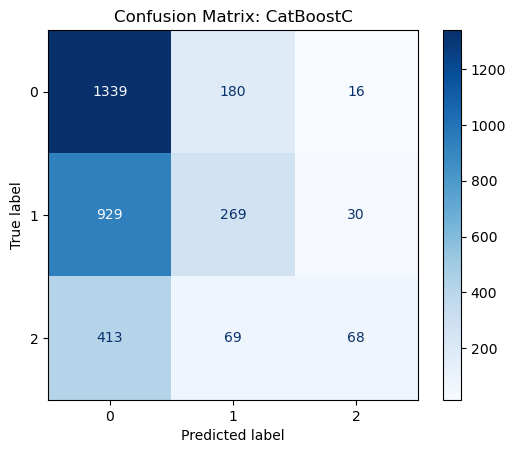

Model saved at: ml_model\ml_CatBoostC_WordBigram.joblib

Evaluating XGBoost...
Model Evaluation: XGBoost
F1 Score: 0.54770 | Accuracy: 0.58980 | Precision: 0.63049 | Recall: 0.58980 | Training Accuracy: 0.54331 | Validation Accuracy: 0.58980


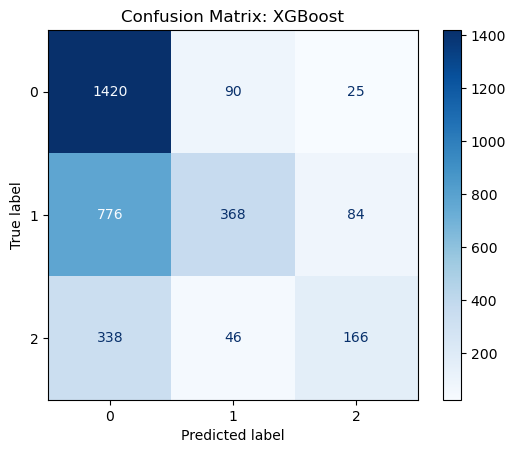

Model saved at: ml_model\ml_XGBoost_WordBigram.joblib

Evaluating MLPC-sgd...
Model Evaluation: MLPC-sgd
F1 Score: 0.62361 | Accuracy: 0.62813 | Precision: 0.63491 | Recall: 0.62813 | Training Accuracy: 0.56360 | Validation Accuracy: 0.62813


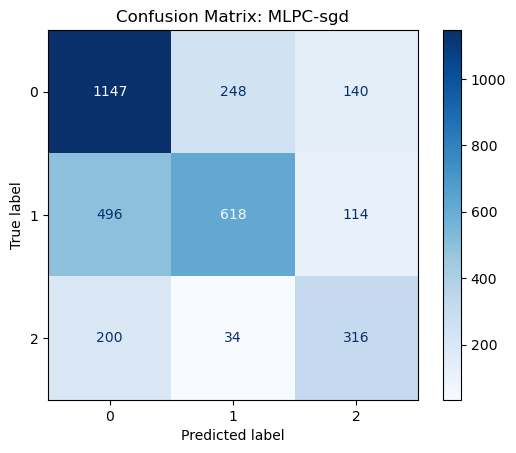

Model saved at: ml_model\ml_MLPC-sgd_WordBigram.joblib

Evaluating ExtraTreesC...
Model Evaluation: ExtraTreesC
F1 Score: 0.73958 | Accuracy: 0.74343 | Precision: 0.74817 | Recall: 0.74343 | Training Accuracy: 0.77037 | Validation Accuracy: 0.74343


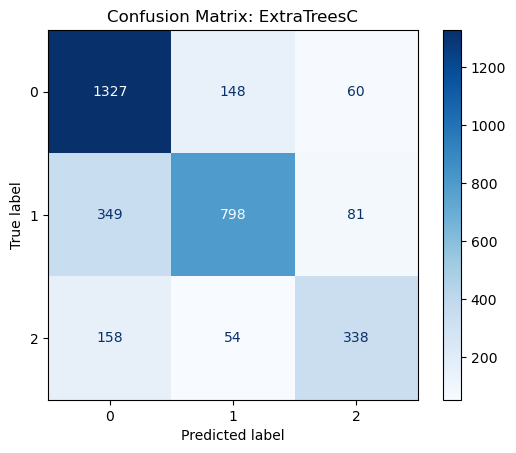

Model saved at: ml_model\ml_ExtraTreesC_WordBigram.joblib


In [60]:
df_WB_ml = evaluate_multiple_models(
    X_train_vec,X_test_vec,
    y_train_vec,y_test_vec,
    modelsAndNames,
    vectorization_method="WordBigram"
)

In [61]:
results_df = pd.concat([results_df, df_WB_ml], ignore_index=True)


WordBigram:
Epoch [1/50], Train Loss: 0.7915, Train Accuracy: 0.7497, Validation Loss: 1.3854, Validation Accuracy: 0.1660
Epoch [2/50], Train Loss: 0.6972, Train Accuracy: 0.8513, Validation Loss: 1.3849, Validation Accuracy: 0.1663
Epoch [3/50], Train Loss: 0.6699, Train Accuracy: 0.8798, Validation Loss: 1.3850, Validation Accuracy: 0.1663
Epoch [4/50], Train Loss: 0.6560, Train Accuracy: 0.8940, Validation Loss: 1.3849, Validation Accuracy: 0.1663
Epoch [5/50], Train Loss: 0.6502, Train Accuracy: 0.9002, Validation Loss: 1.3694, Validation Accuracy: 0.1745
Epoch [6/50], Train Loss: 0.6454, Train Accuracy: 0.9053, Validation Loss: 1.3311, Validation Accuracy: 0.2098
Epoch [7/50], Train Loss: 0.6415, Train Accuracy: 0.9091, Validation Loss: 1.2697, Validation Accuracy: 0.2680
Epoch [8/50], Train Loss: 0.6414, Train Accuracy: 0.9091, Validation Loss: 1.1934, Validation Accuracy: 0.3432
Epoch [9/50], Train Loss: 0.6374, Train Accuracy: 0.9128, Validation Loss: 1.2681, Validation Accur

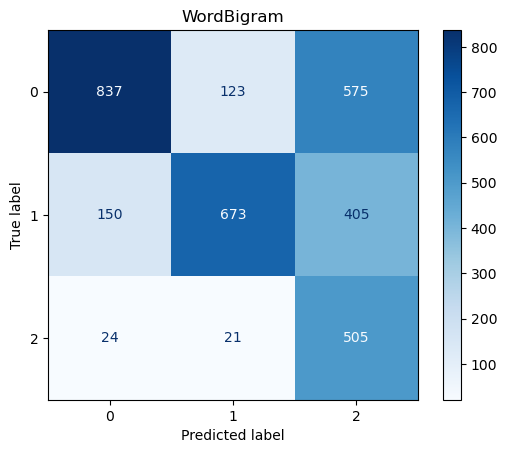

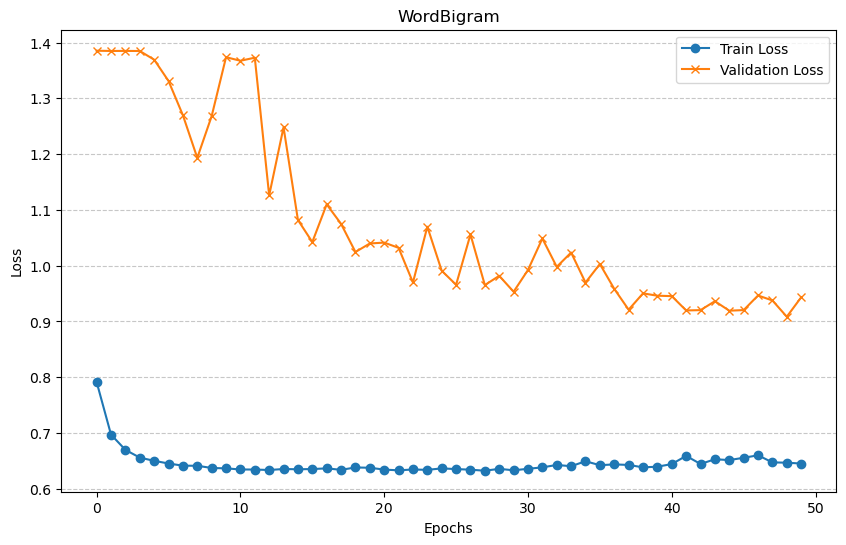

Model saved to models/WordBigram_ANN.pth
Results saved to models/WordBigram_results.csv
Model training completed successfully.
Model metric saved


In [62]:
try:
    df_WB = model_training("WordBigram", X_train_vec, X_test_vec, y_train_vec, y_test_vec,len_labels)

except Exception as e:
    print("An error occurred during model training:")
    print(e)
    clear_memory()

else:
    print("Model training completed successfully.")
    results_df = pd.concat([results_df, df_WB], ignore_index=True)
    print("Model metric saved")

In [63]:
clear_memory()

Cleared memory.
now memory used: 4107.54 MB


# Char Bigram-------------------------------------------

In [65]:
feature_union = FeatureUnion([
    ("char_bigram_count", char_bigram_count),
    ("char_bigram_tfidf", char_bigram_tfidf)
])

In [66]:
X_train_vec,X_test_vec,y_train_vec,y_test_vec = makeVector(feature_union,X_train,X_test,y_train,y_test)

y_train shape: (13250,)
First 10 feature names: ['char_bigram_count__ 0' 'char_bigram_count__ 1' 'char_bigram_count__ 2'
 'char_bigram_count__ 3' 'char_bigram_count__ 4' 'char_bigram_count__ 5'
 'char_bigram_count__ 6' 'char_bigram_count__ 7' 'char_bigram_count__ 8'
 'char_bigram_count__ 9']
X_train_features shape: (13250, 3142)
X_test_features shape: (3313, 3142)
Before sampling Counter({0: 6342, 1: 4778, 2: 2130})
After sampling Counter({0: 6342, 2: 6342, 1: 6342})
X_train shape: (19026, 3142),y_train shape: (19026,),



Evaluating CatBoostC...
Model Evaluation: CatBoostC
F1 Score: 0.56378 | Accuracy: 0.56052 | Precision: 0.57827 | Recall: 0.56052 | Training Accuracy: 0.55913 | Validation Accuracy: 0.56052


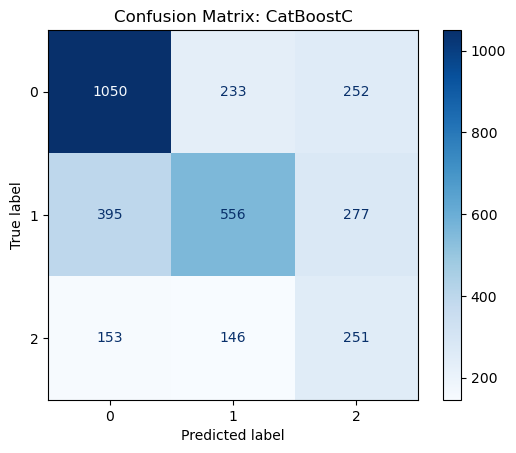

Model saved at: ml_model\ml_CatBoostC_CharBigram.joblib

Evaluating XGBoost...
Model Evaluation: XGBoost
F1 Score: 0.75754 | Accuracy: 0.75943 | Precision: 0.75738 | Recall: 0.75943 | Training Accuracy: 0.74440 | Validation Accuracy: 0.75943


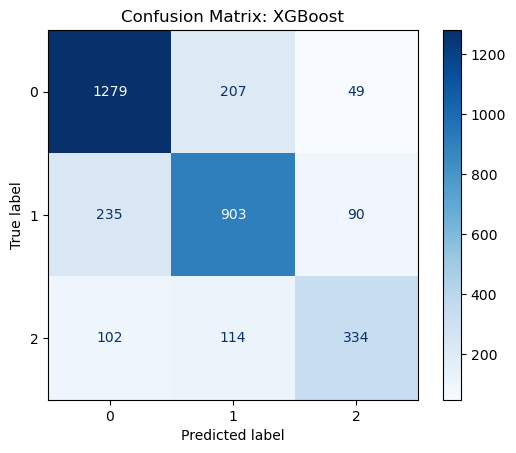

Model saved at: ml_model\ml_XGBoost_CharBigram.joblib

Evaluating MLPC-sgd...
Model Evaluation: MLPC-sgd
F1 Score: 0.65410 | Accuracy: 0.65168 | Precision: 0.65888 | Recall: 0.65168 | Training Accuracy: 0.64501 | Validation Accuracy: 0.65168


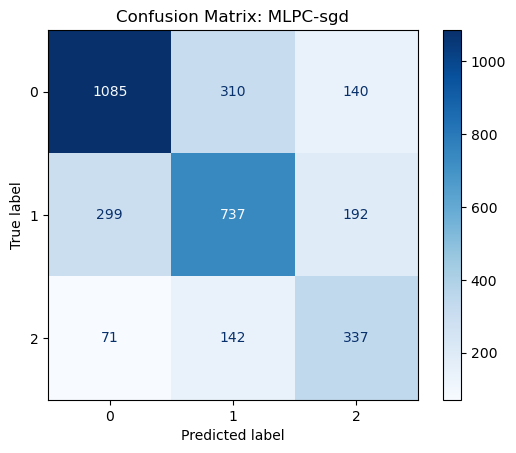

Model saved at: ml_model\ml_MLPC-sgd_CharBigram.joblib

Evaluating ExtraTreesC...
Model Evaluation: ExtraTreesC
F1 Score: 0.81961 | Accuracy: 0.82372 | Precision: 0.83467 | Recall: 0.82372 | Training Accuracy: 0.87133 | Validation Accuracy: 0.82372


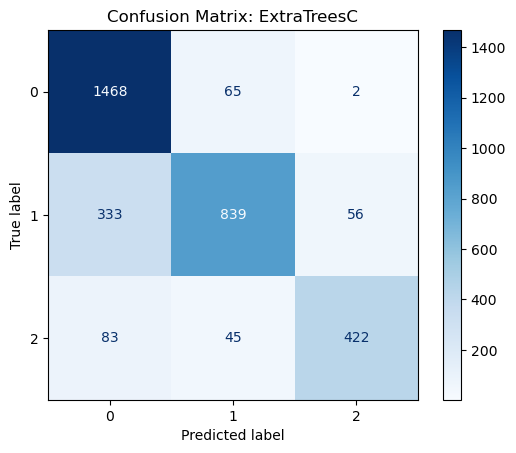

Model saved at: ml_model\ml_ExtraTreesC_CharBigram.joblib


In [67]:
df_CB_ml = evaluate_multiple_models(
    X_train_vec,X_test_vec,
    y_train_vec,y_test_vec,
    modelsAndNames,
    vectorization_method="CharBigram"
)

In [68]:
results_df = pd.concat([results_df, df_CB_ml], ignore_index=True)


CharBigram:
Epoch [1/50], Train Loss: 0.8224, Train Accuracy: 0.7163, Validation Loss: 1.3830, Validation Accuracy: 0.1678
Epoch [2/50], Train Loss: 0.8058, Train Accuracy: 0.7379, Validation Loss: 1.3854, Validation Accuracy: 0.1660
Epoch [3/50], Train Loss: 0.8388, Train Accuracy: 0.7072, Validation Loss: 1.3780, Validation Accuracy: 0.1733
Epoch [4/50], Train Loss: 0.7716, Train Accuracy: 0.7749, Validation Loss: 1.3686, Validation Accuracy: 0.1829
Epoch [5/50], Train Loss: 0.7644, Train Accuracy: 0.7834, Validation Loss: 1.3792, Validation Accuracy: 0.1708
Epoch [6/50], Train Loss: 0.7585, Train Accuracy: 0.7911, Validation Loss: 1.3626, Validation Accuracy: 0.1880
Epoch [7/50], Train Loss: 0.7457, Train Accuracy: 0.8026, Validation Loss: 1.3425, Validation Accuracy: 0.2050
Epoch [8/50], Train Loss: 0.7383, Train Accuracy: 0.8110, Validation Loss: 1.3567, Validation Accuracy: 0.1944
Epoch [9/50], Train Loss: 0.7342, Train Accuracy: 0.8145, Validation Loss: 1.3612, Validation Accur

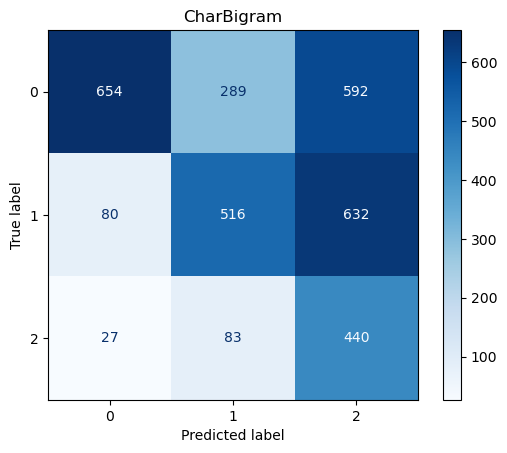

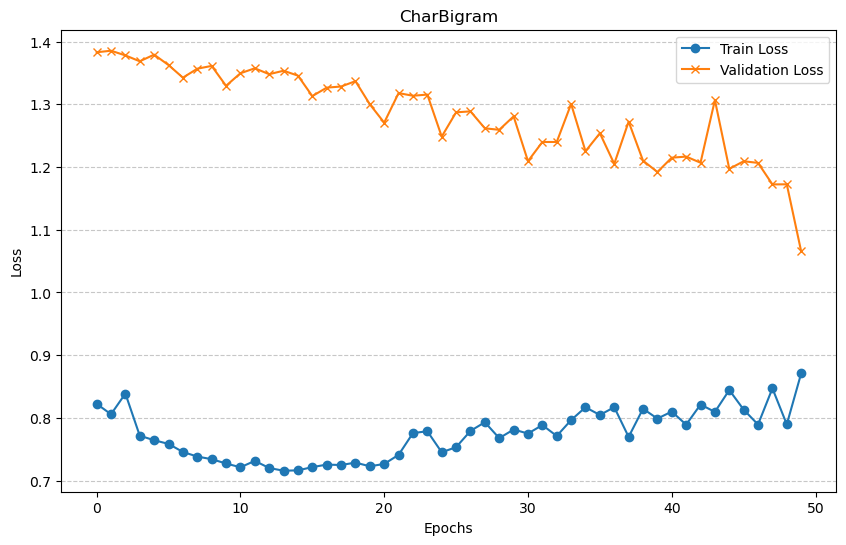

Model saved to models/CharBigram_ANN.pth
Results saved to models/CharBigram_results.csv
Model training completed successfully.
Model metric saved


In [69]:
try:
    df_CB = model_training( "CharBigram", X_train_vec, X_test_vec, y_train_vec, y_test_vec,len_labels)

except Exception as e:
    print("An error occurred during model training:")
    print(e)
    clear_memory()

else:
    print("Model training completed successfully.")
    results_df = pd.concat([results_df, df_CB], ignore_index=True)
    print("Model metric saved")

In [70]:
clear_memory()

Cleared memory.
now memory used: 1830.09 MB


# Char Trigram-------------------------------------------

In [72]:
feature_union = FeatureUnion([
    ("char_trigram_count", char_trigram_count),
    ("char_trigram_tfidf", char_trigram_tfidf)
])

In [73]:
X_train_vec,X_test_vec,y_train_vec,y_test_vec = makeVector(feature_union,X_train,X_test,y_train,y_test)

y_train shape: (13250,)
First 10 feature names: ['char_trigram_count__ 00' 'char_trigram_count__ 01'
 'char_trigram_count__ 02' 'char_trigram_count__ 03'
 'char_trigram_count__ 05' 'char_trigram_count__ 07'
 'char_trigram_count__ 08' 'char_trigram_count__ 09'
 'char_trigram_count__ 10' 'char_trigram_count__ 11']
X_train_features shape: (13250, 18000)
X_test_features shape: (3313, 18000)
Before sampling Counter({0: 6342, 1: 4778, 2: 2130})
After sampling Counter({0: 6342, 2: 6342, 1: 6342})
X_train shape: (19026, 18000),y_train shape: (19026,),



Evaluating CatBoostC...
Model Evaluation: CatBoostC
F1 Score: 0.56847 | Accuracy: 0.56444 | Precision: 0.58376 | Recall: 0.56444 | Training Accuracy: 0.57632 | Validation Accuracy: 0.56444


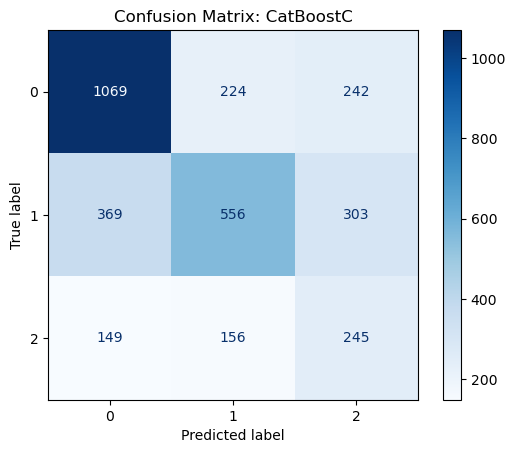

Model saved at: ml_model\ml_CatBoostC_CharTrigram.joblib

Evaluating XGBoost...
Model Evaluation: XGBoost
F1 Score: 0.74861 | Accuracy: 0.75128 | Precision: 0.74864 | Recall: 0.75128 | Training Accuracy: 0.75213 | Validation Accuracy: 0.75128


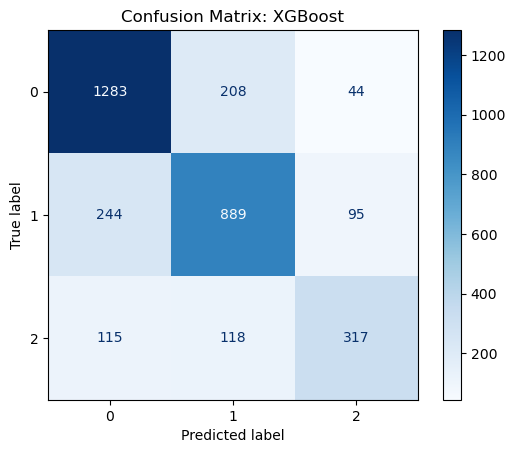

Model saved at: ml_model\ml_XGBoost_CharTrigram.joblib

Evaluating MLPC-sgd...
Model Evaluation: MLPC-sgd
F1 Score: 0.80845 | Accuracy: 0.80773 | Precision: 0.81106 | Recall: 0.80773 | Training Accuracy: 0.83565 | Validation Accuracy: 0.80773


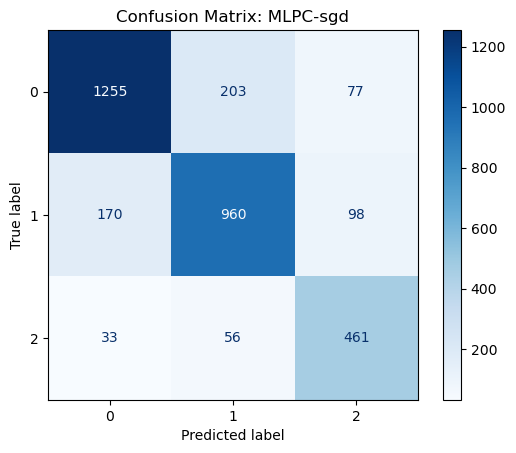

Model saved at: ml_model\ml_MLPC-sgd_CharTrigram.joblib

Evaluating ExtraTreesC...
Model Evaluation: ExtraTreesC
F1 Score: 0.84225 | Accuracy: 0.84576 | Precision: 0.85403 | Recall: 0.84576 | Training Accuracy: 0.88437 | Validation Accuracy: 0.84576


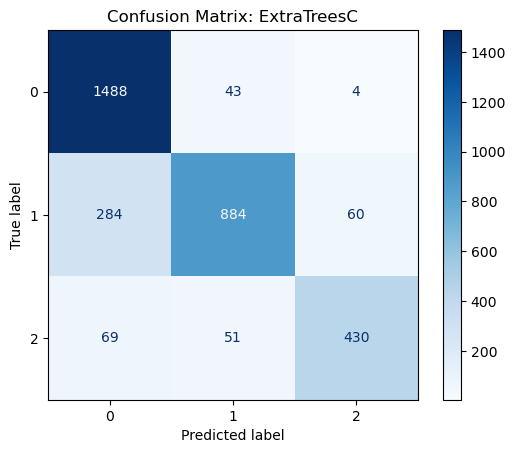

Model saved at: ml_model\ml_ExtraTreesC_CharTrigram.joblib


In [74]:
df_CT_ml = evaluate_multiple_models(
    X_train_vec,X_test_vec,
    y_train_vec,y_test_vec,
    modelsAndNames,
    vectorization_method="CharTrigram"
)

In [75]:
results_df = pd.concat([results_df, df_CT_ml], ignore_index=True)


CharTrigram:
Epoch [1/50], Train Loss: 0.7887, Train Accuracy: 0.7542, Validation Loss: 1.3853, Validation Accuracy: 0.1660
Epoch [2/50], Train Loss: 0.7261, Train Accuracy: 0.8212, Validation Loss: 1.3854, Validation Accuracy: 0.1660
Epoch [3/50], Train Loss: 0.6982, Train Accuracy: 0.8514, Validation Loss: 1.3846, Validation Accuracy: 0.1660
Epoch [4/50], Train Loss: 0.6704, Train Accuracy: 0.8793, Validation Loss: 1.3840, Validation Accuracy: 0.1660
Epoch [5/50], Train Loss: 0.6531, Train Accuracy: 0.8973, Validation Loss: 1.3542, Validation Accuracy: 0.1935
Epoch [6/50], Train Loss: 0.6434, Train Accuracy: 0.9075, Validation Loss: 1.3834, Validation Accuracy: 0.1660
Epoch [7/50], Train Loss: 0.6346, Train Accuracy: 0.9163, Validation Loss: 1.3831, Validation Accuracy: 0.1663
Epoch [8/50], Train Loss: 0.6303, Train Accuracy: 0.9207, Validation Loss: 1.2190, Validation Accuracy: 0.3299
Epoch [9/50], Train Loss: 0.6235, Train Accuracy: 0.9273, Validation Loss: 1.3625, Validation Accu

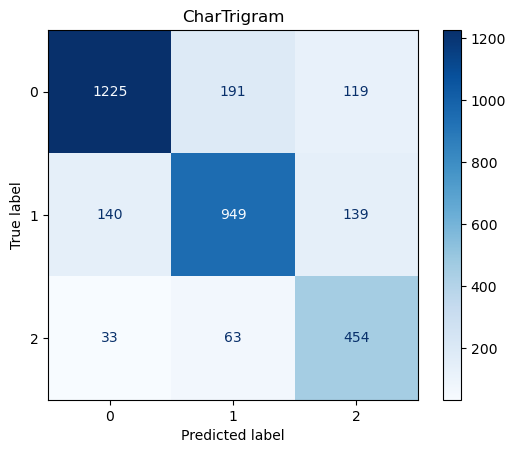

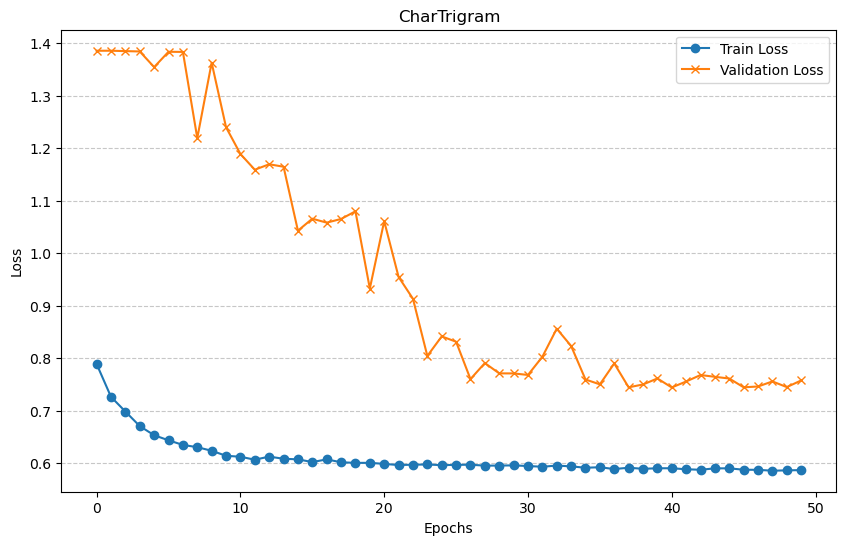

Model saved to models/CharTrigram_ANN.pth
Results saved to models/CharTrigram_results.csv
Model training completed successfully.
Model metric saved


In [76]:
try:
    df_CT = model_training( "CharTrigram", X_train_vec, X_test_vec, y_train_vec, y_test_vec,len_labels)

except Exception as e:
    print("An error occurred during model training:")
    print(e)
    clear_memory()

else:
    print("Model training completed successfully.")
    results_df = pd.concat([results_df, df_CT], ignore_index=True)
    print("Model metric saved")

In [77]:
clear_memory()

Cleared memory.
now memory used: 4084.88 MB


# Char Bigram + Char Trigram-------------------------------------------

In [79]:
feature_union = FeatureUnion([
    ("word_bigram_count", word_bigram_count),
    ("word_bigram_tfidf", word_bigram_tfidf),

    ("char_trigram_count", char_trigram_count),
    ("char_trigram_tfidf", char_trigram_tfidf)
])

In [80]:
X_train_vec,X_test_vec,y_train_vec,y_test_vec = makeVector(feature_union,X_train,X_test,y_train,y_test)

y_train shape: (13250,)
First 10 feature names: ['word_bigram_count__000 000' 'word_bigram_count__07 anafartalar'
 'word_bigram_count__08 güngören' 'word_bigram_count__10 bin'
 'word_bigram_count__10 gün' 'word_bigram_count__10 kasım'
 'word_bigram_count__10 milyon' 'word_bigram_count__10 sığınmacının'
 'word_bigram_count__10 yıl' 'word_bigram_count__10 yılda']
X_train_features shape: (13250, 36000)
X_test_features shape: (3313, 36000)
Before sampling Counter({0: 6342, 1: 4778, 2: 2130})
After sampling Counter({0: 6342, 2: 6342, 1: 6342})
X_train shape: (19026, 36000),y_train shape: (19026,),



Evaluating CatBoostC...
Model Evaluation: CatBoostC
F1 Score: 0.56776 | Accuracy: 0.56505 | Precision: 0.58458 | Recall: 0.56505 | Training Accuracy: 0.57852 | Validation Accuracy: 0.56505


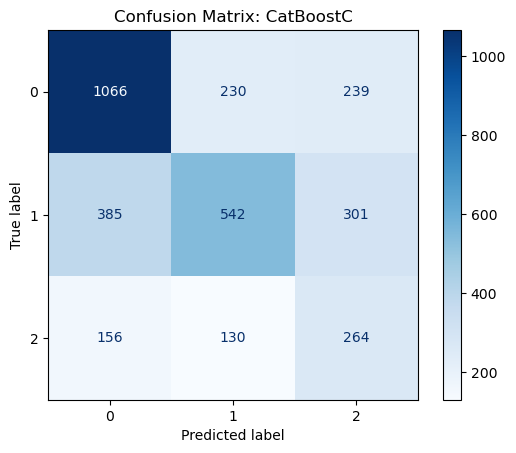

Model saved at: ml_model\ml_CatBoostC_ChBigram+ChTrigram.joblib

Evaluating XGBoost...
Model Evaluation: XGBoost
F1 Score: 0.74702 | Accuracy: 0.75038 | Precision: 0.74756 | Recall: 0.75038 | Training Accuracy: 0.75213 | Validation Accuracy: 0.75038


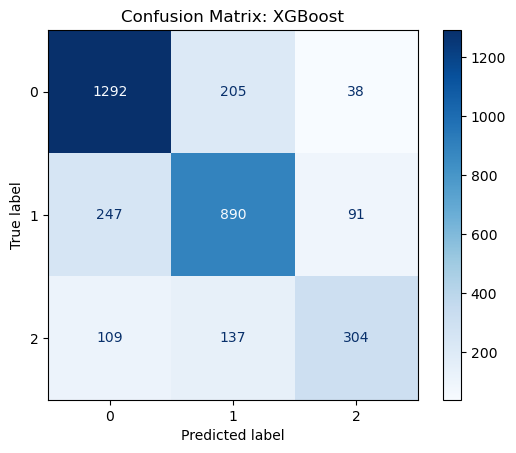

Model saved at: ml_model\ml_XGBoost_ChBigram+ChTrigram.joblib

Evaluating MLPC-sgd...
Model Evaluation: MLPC-sgd
F1 Score: 0.83028 | Accuracy: 0.82976 | Precision: 0.83168 | Recall: 0.82976 | Training Accuracy: 0.85593 | Validation Accuracy: 0.82976


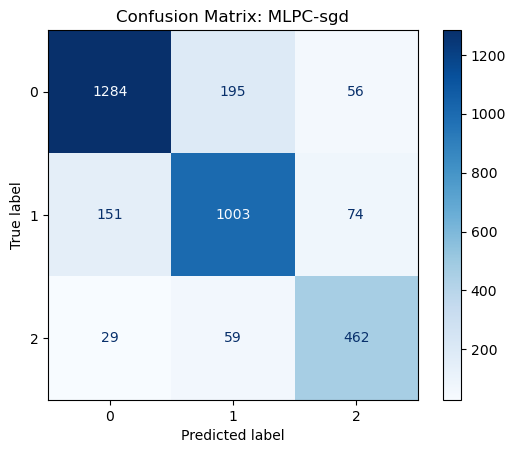

Model saved at: ml_model\ml_MLPC-sgd_ChBigram+ChTrigram.joblib

Evaluating ExtraTreesC...
Model Evaluation: ExtraTreesC
F1 Score: 0.84103 | Accuracy: 0.84485 | Precision: 0.85444 | Recall: 0.84485 | Training Accuracy: 0.88132 | Validation Accuracy: 0.84485


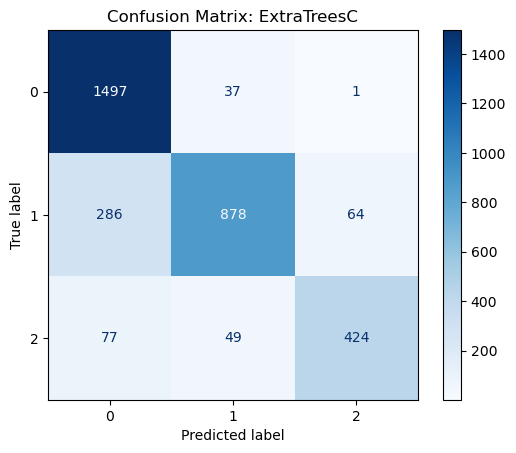

Model saved at: ml_model\ml_ExtraTreesC_ChBigram+ChTrigram.joblib


In [81]:
df_CBCT_ml = evaluate_multiple_models(
    X_train_vec,X_test_vec,
    y_train_vec,y_test_vec,
    modelsAndNames,
    vectorization_method="ChBigram+ChTrigram"
)

In [82]:
results_df = pd.concat([results_df, df_CBCT_ml], ignore_index=True)


ChBigram+ChTrigram:
Epoch [1/50], Train Loss: 0.7813, Train Accuracy: 0.7617, Validation Loss: 1.3854, Validation Accuracy: 0.1660
Epoch [2/50], Train Loss: 0.7118, Train Accuracy: 0.8369, Validation Loss: 1.3792, Validation Accuracy: 0.1702
Epoch [3/50], Train Loss: 0.6660, Train Accuracy: 0.8841, Validation Loss: 1.3847, Validation Accuracy: 0.1660
Epoch [4/50], Train Loss: 0.6459, Train Accuracy: 0.9052, Validation Loss: 1.3822, Validation Accuracy: 0.1675
Epoch [5/50], Train Loss: 0.6364, Train Accuracy: 0.9141, Validation Loss: 1.2569, Validation Accuracy: 0.2913
Epoch [6/50], Train Loss: 0.6229, Train Accuracy: 0.9282, Validation Loss: 1.3405, Validation Accuracy: 0.2083
Epoch [7/50], Train Loss: 0.6194, Train Accuracy: 0.9318, Validation Loss: 1.2383, Validation Accuracy: 0.3109
Epoch [8/50], Train Loss: 0.6137, Train Accuracy: 0.9374, Validation Loss: 1.2454, Validation Accuracy: 0.3049
Epoch [9/50], Train Loss: 0.6150, Train Accuracy: 0.9360, Validation Loss: 1.1425, Validati

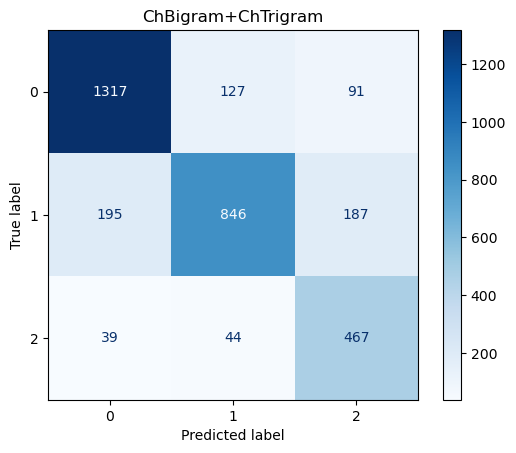

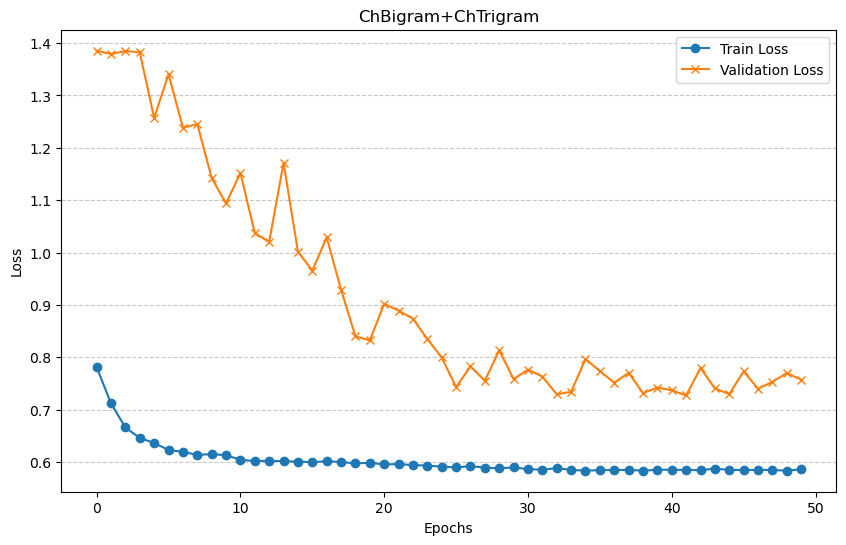

Model saved to models/ChBigram+ChTrigram_ANN.pth
Results saved to models/ChBigram+ChTrigram_results.csv
Model training completed successfully.
Model metric saved


In [83]:
try:
    df_CBCT = model_training( "ChBigram+ChTrigram",
                               X_train_vec, X_test_vec,
                               y_train_vec, y_test_vec,
                               len_labels)

except Exception as e:
    print("An error occurred during model training:")
    print(e)
    clear_memory()

else:
    print("Model training completed successfully.")
    results_df = pd.concat([results_df, df_CBCT], ignore_index=True)
    print("Model metric saved")

In [84]:
clear_memory()

Cleared memory.
now memory used: 7082.27 MB


# Char Unigram + Char Trigram-------------------------------------------

In [86]:
feature_union = FeatureUnion([
    ("word_unigram_count", word_unigram_count),
    ("word_unigram_tfidf", word_unigram_tfidf),

    ("char_trigram_count", char_trigram_count),
    ("char_trigram_tfidf", char_trigram_tfidf)

])

In [87]:
X_train_vec,X_test_vec,y_train_vec,y_test_vec = makeVector(feature_union,X_train,X_test,y_train,y_test)

y_train shape: (13250,)
First 10 feature names: ['word_unigram_count__00' 'word_unigram_count__000'
 'word_unigram_count__02' 'word_unigram_count__0332'
 'word_unigram_count__05' 'word_unigram_count__07'
 'word_unigram_count__08' 'word_unigram_count__09'
 'word_unigram_count__10' 'word_unigram_count__100']
X_train_features shape: (13250, 36000)
X_test_features shape: (3313, 36000)
Before sampling Counter({0: 6342, 1: 4778, 2: 2130})
After sampling Counter({0: 6342, 2: 6342, 1: 6342})
X_train shape: (19026, 36000),y_train shape: (19026,),



Evaluating CatBoostC...
Model Evaluation: CatBoostC
F1 Score: 0.56450 | Accuracy: 0.56142 | Precision: 0.57963 | Recall: 0.56142 | Training Accuracy: 0.57816 | Validation Accuracy: 0.56142


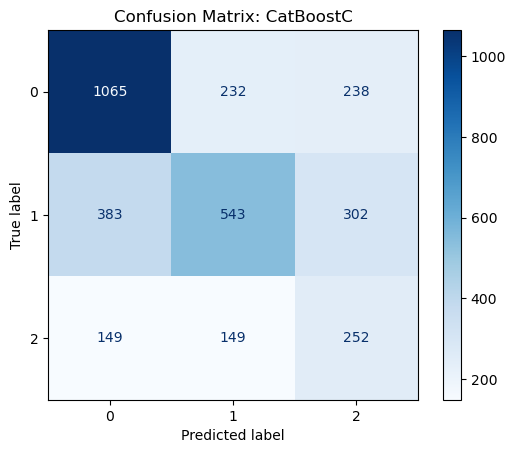

Model saved at: ml_model\ml_CatBoostC_ChUnigram+ChTrigram.joblib

Evaluating XGBoost...
Model Evaluation: XGBoost
F1 Score: 0.74427 | Accuracy: 0.74676 | Precision: 0.74396 | Recall: 0.74676 | Training Accuracy: 0.74819 | Validation Accuracy: 0.74676


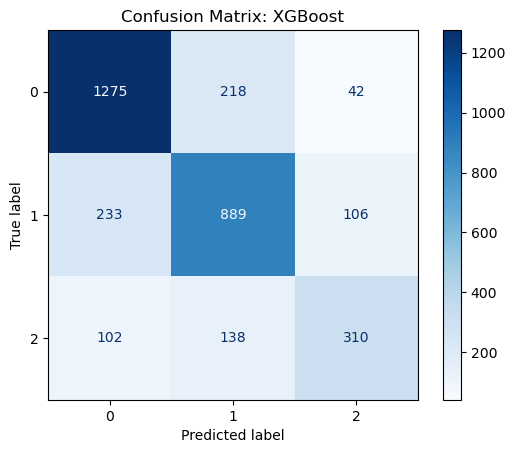

Model saved at: ml_model\ml_XGBoost_ChUnigram+ChTrigram.joblib

Evaluating MLPC-sgd...
Model Evaluation: MLPC-sgd
F1 Score: 0.83439 | Accuracy: 0.83369 | Precision: 0.83628 | Recall: 0.83369 | Training Accuracy: 0.86408 | Validation Accuracy: 0.83369


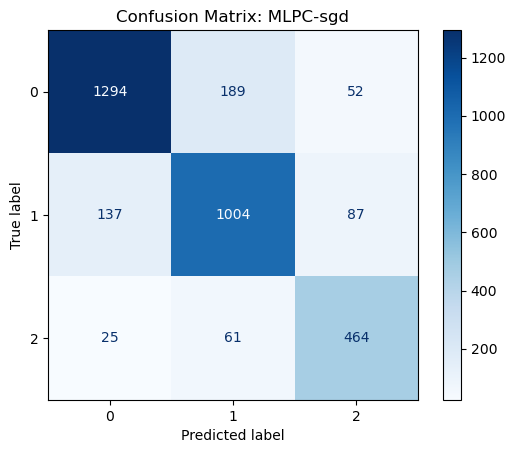

Model saved at: ml_model\ml_MLPC-sgd_ChUnigram+ChTrigram.joblib

Evaluating ExtraTreesC...
Model Evaluation: ExtraTreesC
F1 Score: 0.84328 | Accuracy: 0.84666 | Precision: 0.85492 | Recall: 0.84666 | Training Accuracy: 0.88637 | Validation Accuracy: 0.84666


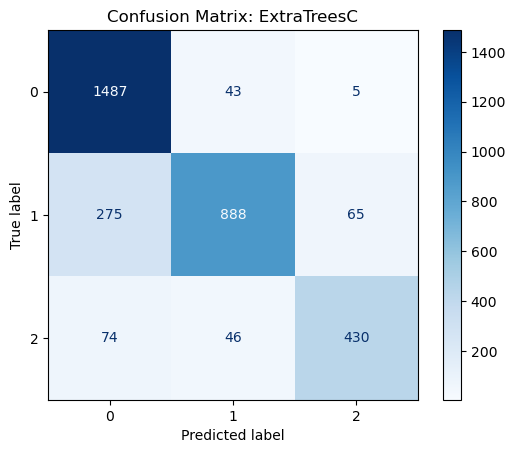

Model saved at: ml_model\ml_ExtraTreesC_ChUnigram+ChTrigram.joblib


In [88]:
df_CUCT_ml = evaluate_multiple_models(
    X_train_vec,X_test_vec,
    y_train_vec,y_test_vec,
    modelsAndNames,
    vectorization_method="ChUnigram+ChTrigram"
)

In [89]:
results_df = pd.concat([results_df, df_CUCT_ml], ignore_index=True)


ChUnigram+ChTrigram:
Epoch [1/50], Train Loss: 0.7793, Train Accuracy: 0.7651, Validation Loss: 1.3852, Validation Accuracy: 0.1660
Epoch [2/50], Train Loss: 0.7027, Train Accuracy: 0.8457, Validation Loss: 1.3854, Validation Accuracy: 0.1660
Epoch [3/50], Train Loss: 0.7052, Train Accuracy: 0.8449, Validation Loss: 1.3785, Validation Accuracy: 0.1708
Epoch [4/50], Train Loss: 0.6481, Train Accuracy: 0.9023, Validation Loss: 1.3848, Validation Accuracy: 0.1660
Epoch [5/50], Train Loss: 0.6384, Train Accuracy: 0.9122, Validation Loss: 1.3665, Validation Accuracy: 0.1826
Epoch [6/50], Train Loss: 0.6271, Train Accuracy: 0.9235, Validation Loss: 1.2488, Validation Accuracy: 0.2991
Epoch [7/50], Train Loss: 0.6133, Train Accuracy: 0.9378, Validation Loss: 1.1184, Validation Accuracy: 0.4289
Epoch [8/50], Train Loss: 0.6060, Train Accuracy: 0.9451, Validation Loss: 1.1902, Validation Accuracy: 0.3604
Epoch [9/50], Train Loss: 0.6035, Train Accuracy: 0.9478, Validation Loss: 1.1716, Validat

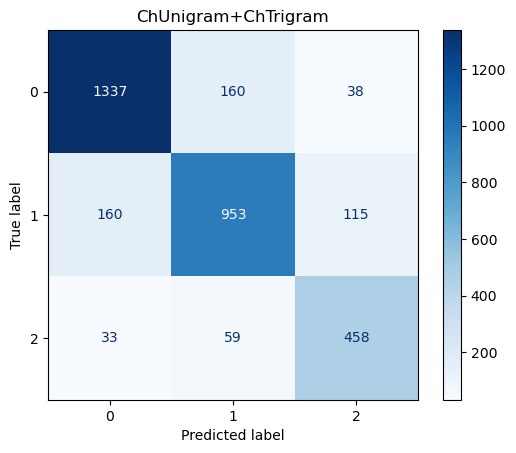

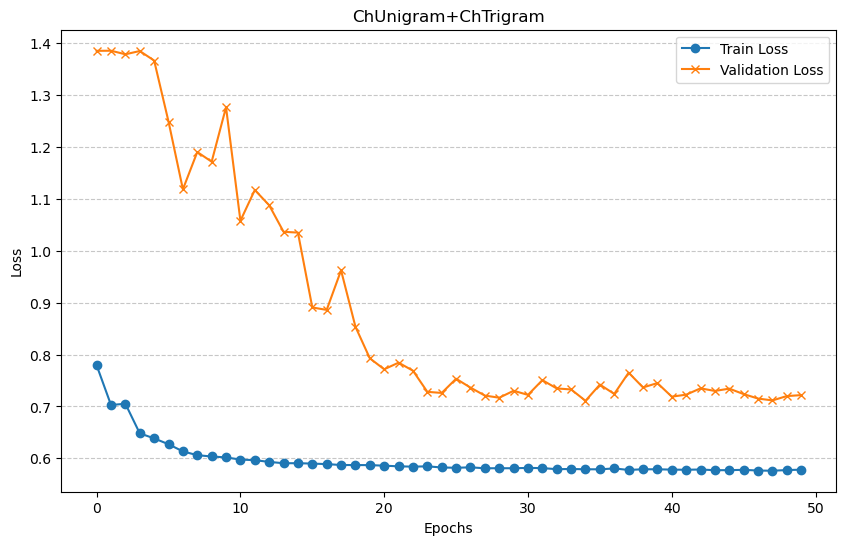

Model saved to models/ChUnigram+ChTrigram_ANN.pth
Results saved to models/ChUnigram+ChTrigram_results.csv
Model training completed successfully.
Model metric saved


In [90]:
try:
    df_CUCT = model_training( "ChUnigram+ChTrigram",
                               X_train_vec, X_test_vec,
                               y_train_vec, y_test_vec,
                               len_labels)

except Exception as e:
    print("An error occurred during model training:")
    print(e)
    clear_memory()

else:
    print("Model training completed successfully.")
    results_df = pd.concat([results_df, df_CUCT], ignore_index=True)
    print("Model metric saved")

In [91]:
clear_memory()

Cleared memory.
now memory used: 7054.39 MB


# Word Unigram + Word Bigram + Char Trigram -------------------------------------------

In [93]:
feature_union = FeatureUnion([
    ("word_unigram_count", word_unigram_count),
    ("word_unigram_tfidf", word_unigram_tfidf),

    ("char_bigram_count", char_bigram_count),
    ("char_bigram_tfidf", char_bigram_tfidf),

    ("char_trigram_count", char_trigram_count),
    ("char_trigram_tfidf", char_trigram_tfidf)

])

In [94]:
X_train_vec,X_test_vec,y_train_vec,y_test_vec = makeVector(feature_union,X_train,X_test,y_train,y_test)

y_train shape: (13250,)
First 10 feature names: ['word_unigram_count__00' 'word_unigram_count__000'
 'word_unigram_count__02' 'word_unigram_count__0332'
 'word_unigram_count__05' 'word_unigram_count__07'
 'word_unigram_count__08' 'word_unigram_count__09'
 'word_unigram_count__10' 'word_unigram_count__100']
X_train_features shape: (13250, 39142)
X_test_features shape: (3313, 39142)
Before sampling Counter({0: 6342, 1: 4778, 2: 2130})
After sampling Counter({0: 6342, 2: 6342, 1: 6342})
X_train shape: (19026, 39142),y_train shape: (19026,),



Evaluating CatBoostC...
Model Evaluation: CatBoostC
F1 Score: 0.57780 | Accuracy: 0.57531 | Precision: 0.59377 | Recall: 0.57531 | Training Accuracy: 0.58026 | Validation Accuracy: 0.57531


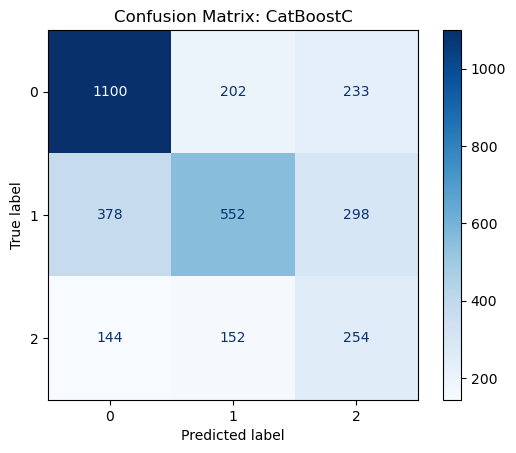

Model saved at: ml_model\ml_CatBoostC_WUniG+WBiG+ChTriG.joblib

Evaluating XGBoost...
Model Evaluation: XGBoost
F1 Score: 0.77020 | Accuracy: 0.77241 | Precision: 0.77002 | Recall: 0.77241 | Training Accuracy: 0.75570 | Validation Accuracy: 0.77241


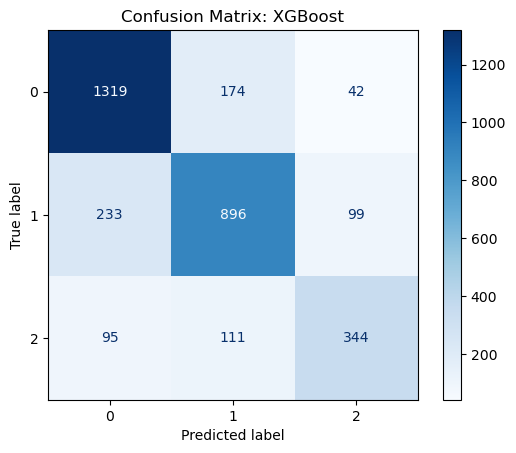

Model saved at: ml_model\ml_XGBoost_WUniG+WBiG+ChTriG.joblib

Evaluating MLPC-sgd...
Model Evaluation: MLPC-sgd
F1 Score: 0.83253 | Accuracy: 0.83187 | Precision: 0.83415 | Recall: 0.83187 | Training Accuracy: 0.87196 | Validation Accuracy: 0.83187


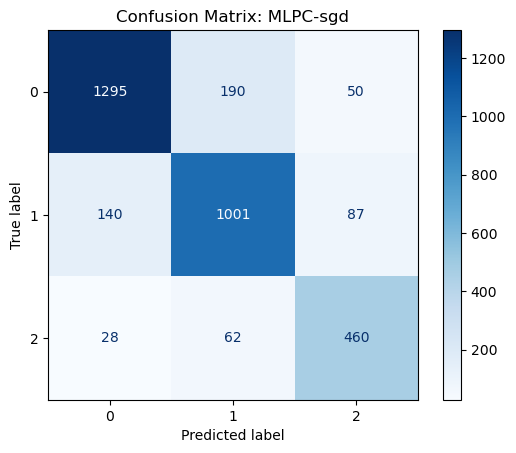

Model saved at: ml_model\ml_MLPC-sgd_WUniG+WBiG+ChTriG.joblib

Evaluating ExtraTreesC...
Model Evaluation: ExtraTreesC
F1 Score: 0.84238 | Accuracy: 0.84606 | Precision: 0.85548 | Recall: 0.84606 | Training Accuracy: 0.88726 | Validation Accuracy: 0.84606


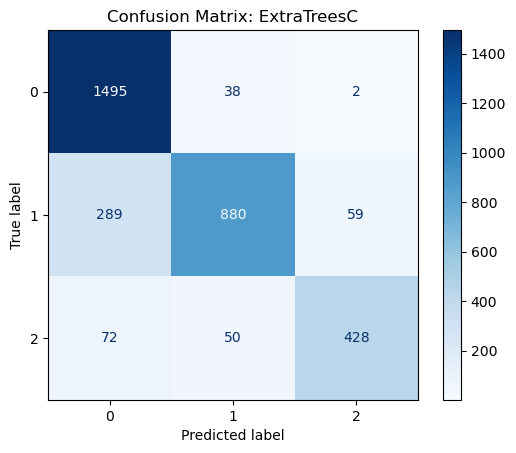

Model saved at: ml_model\ml_ExtraTreesC_WUniG+WBiG+ChTriG.joblib


In [95]:
df_WUWBCT_ml = evaluate_multiple_models(
    X_train_vec,X_test_vec,
    y_train_vec,y_test_vec,
    modelsAndNames,
    vectorization_method="WUniG+WBiG+ChTriG"
)

In [96]:
results_df = pd.concat([results_df, df_WUWBCT_ml], ignore_index=True)


WUniG+WBiG+ChTriG:
Epoch [1/50], Train Loss: 0.7933, Train Accuracy: 0.7498, Validation Loss: 1.3844, Validation Accuracy: 0.1663
Epoch [2/50], Train Loss: 0.7324, Train Accuracy: 0.8157, Validation Loss: 1.3667, Validation Accuracy: 0.1814
Epoch [3/50], Train Loss: 0.7026, Train Accuracy: 0.8470, Validation Loss: 1.3313, Validation Accuracy: 0.2194
Epoch [4/50], Train Loss: 0.7073, Train Accuracy: 0.8423, Validation Loss: 1.3290, Validation Accuracy: 0.2261
Epoch [5/50], Train Loss: 0.6811, Train Accuracy: 0.8697, Validation Loss: 1.3092, Validation Accuracy: 0.2421
Epoch [6/50], Train Loss: 0.6749, Train Accuracy: 0.8757, Validation Loss: 1.2772, Validation Accuracy: 0.2732
Epoch [7/50], Train Loss: 0.6794, Train Accuracy: 0.8717, Validation Loss: 1.2292, Validation Accuracy: 0.3206
Epoch [8/50], Train Loss: 0.6695, Train Accuracy: 0.8816, Validation Loss: 1.3314, Validation Accuracy: 0.2194
Epoch [9/50], Train Loss: 0.6819, Train Accuracy: 0.8693, Validation Loss: 1.2669, Validatio

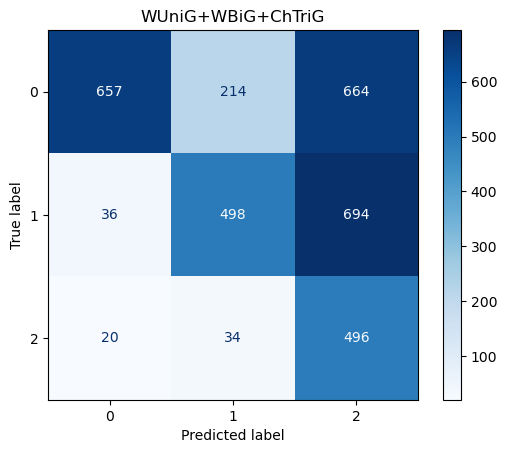

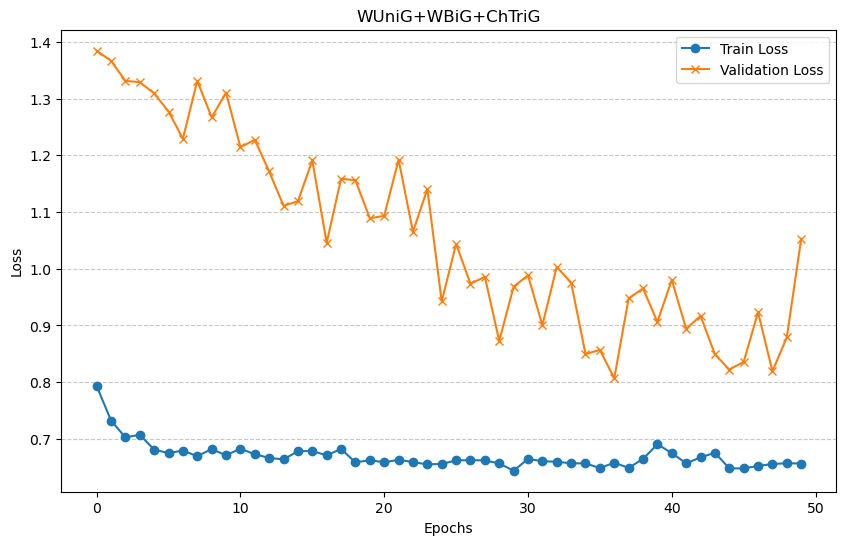

Model saved to models/WUniG+WBiG+ChTriG_ANN.pth
Results saved to models/WUniG+WBiG+ChTriG_results.csv
Model training completed successfully.
Model metric saved


In [97]:
try:
    df_WUWBCT = model_training( "WUniG+WBiG+ChTriG",
                               X_train_vec, X_test_vec,
                               y_train_vec, y_test_vec,
                               len_labels)

except Exception as e:
    print("An error occurred during model training:")
    print(e)
    clear_memory()

else:
    print("Model training completed successfully.")
    results_df = pd.concat([results_df, df_WUWBCT], ignore_index=True)
    print("Model metric saved")

In [98]:
clear_memory()

Cleared memory.
now memory used: 7437.72 MB


# Word Unigram + Word Bigram + Char Bigram + Char Trigram -------------------------------------------


In [100]:
feature_union = FeatureUnion([
    ("word_unigram_count", word_unigram_count),
    ("word_unigram_tfidf", word_unigram_tfidf),

    ("word_bigram_count", word_bigram_count),
    ("word_bigram_tfidf", word_bigram_tfidf),

    ("char_bigram_count", char_bigram_count),
    ("char_bigram_tfidf", char_bigram_tfidf),

    ("char_trigram_count", char_trigram_count),
    ("char_trigram_tfidf", char_trigram_tfidf)

])

In [101]:
X_train_vec,X_test_vec,y_train_vec,y_test_vec = makeVector(feature_union,X_train,X_test,y_train,y_test)

y_train shape: (13250,)
First 10 feature names: ['word_unigram_count__00' 'word_unigram_count__000'
 'word_unigram_count__02' 'word_unigram_count__0332'
 'word_unigram_count__05' 'word_unigram_count__07'
 'word_unigram_count__08' 'word_unigram_count__09'
 'word_unigram_count__10' 'word_unigram_count__100']
X_train_features shape: (13250, 57142)
X_test_features shape: (3313, 57142)
Before sampling Counter({0: 6342, 1: 4778, 2: 2130})
After sampling Counter({0: 6342, 2: 6342, 1: 6342})
X_train shape: (19026, 57142),y_train shape: (19026,),



Evaluating CatBoostC...
Model Evaluation: CatBoostC
F1 Score: 0.58964 | Accuracy: 0.58859 | Precision: 0.60110 | Recall: 0.58859 | Training Accuracy: 0.57989 | Validation Accuracy: 0.58859


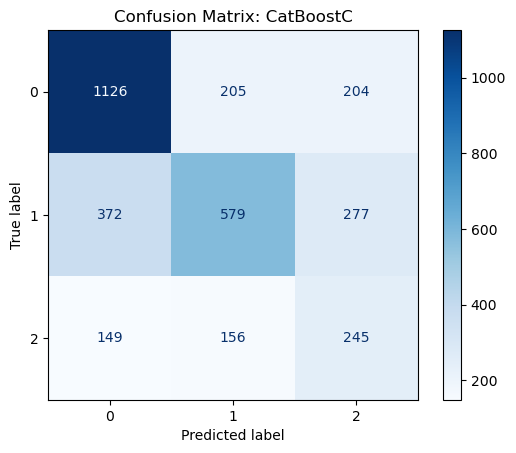

Model saved at: ml_model\ml_CatBoostC_WUniG+WBiG+ChBiG+ChTriG.joblib

Evaluating XGBoost...
Model Evaluation: XGBoost
F1 Score: 0.76937 | Accuracy: 0.77120 | Precision: 0.76922 | Recall: 0.77120 | Training Accuracy: 0.76038 | Validation Accuracy: 0.77120


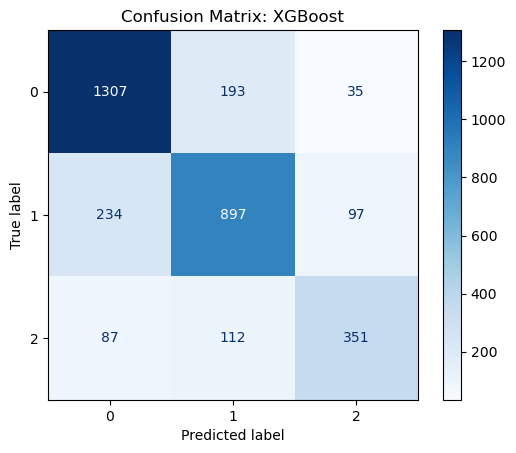

Model saved at: ml_model\ml_XGBoost_WUniG+WBiG+ChBiG+ChTriG.joblib

Evaluating MLPC-sgd...
Model Evaluation: MLPC-sgd
F1 Score: 0.82951 | Accuracy: 0.83097 | Precision: 0.83062 | Recall: 0.83097 | Training Accuracy: 0.86897 | Validation Accuracy: 0.83097


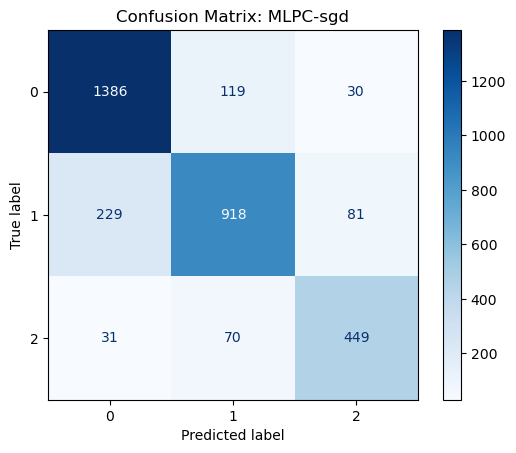

Model saved at: ml_model\ml_MLPC-sgd_WUniG+WBiG+ChBiG+ChTriG.joblib

Evaluating ExtraTreesC...
Model Evaluation: ExtraTreesC
F1 Score: 0.83898 | Accuracy: 0.84274 | Precision: 0.85400 | Recall: 0.84274 | Training Accuracy: 0.88516 | Validation Accuracy: 0.84274


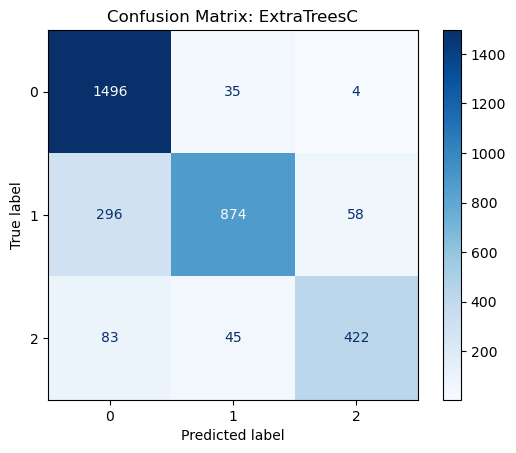

Model saved at: ml_model\ml_ExtraTreesC_WUniG+WBiG+ChBiG+ChTriG.joblib


In [102]:
df_WUWBCBCT_ml = evaluate_multiple_models(
    X_train_vec,X_test_vec,
    y_train_vec,y_test_vec,
    modelsAndNames,
    vectorization_method="WUniG+WBiG+ChBiG+ChTriG"
)

In [103]:
results_df = pd.concat([results_df, df_WUWBCBCT_ml], ignore_index=True)


WUniG+WBiG+ChBiG+ChTriG:
Epoch [1/50], Train Loss: 0.7869, Train Accuracy: 0.7555, Validation Loss: 1.3828, Validation Accuracy: 0.1681
Epoch [2/50], Train Loss: 0.7296, Train Accuracy: 0.8198, Validation Loss: 1.3636, Validation Accuracy: 0.1874
Epoch [3/50], Train Loss: 0.7120, Train Accuracy: 0.8372, Validation Loss: 1.3725, Validation Accuracy: 0.1784
Epoch [4/50], Train Loss: 0.6910, Train Accuracy: 0.8595, Validation Loss: 1.3296, Validation Accuracy: 0.2209
Epoch [5/50], Train Loss: 0.6871, Train Accuracy: 0.8631, Validation Loss: 1.3081, Validation Accuracy: 0.2421
Epoch [6/50], Train Loss: 0.6728, Train Accuracy: 0.8780, Validation Loss: 1.2916, Validation Accuracy: 0.2596
Epoch [7/50], Train Loss: 0.6712, Train Accuracy: 0.8794, Validation Loss: 1.3285, Validation Accuracy: 0.2228
Epoch [8/50], Train Loss: 0.6665, Train Accuracy: 0.8846, Validation Loss: 1.3407, Validation Accuracy: 0.2104
Epoch [9/50], Train Loss: 0.6660, Train Accuracy: 0.8852, Validation Loss: 1.3099, Val

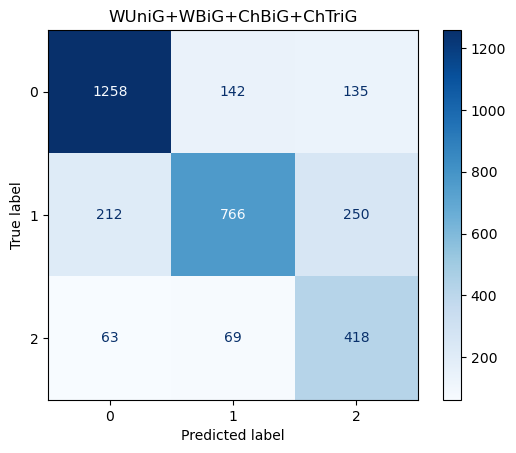

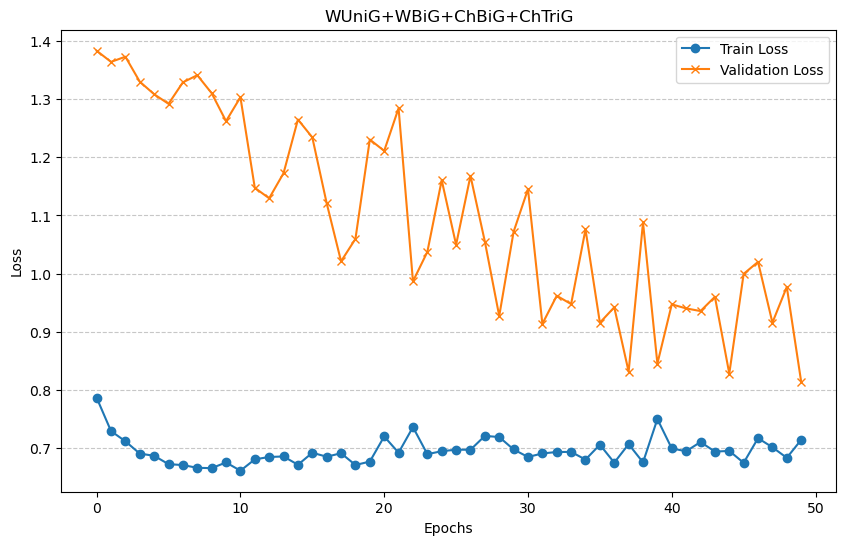

Model saved to models/WUniG+WBiG+ChBiG+ChTriG_ANN.pth
Results saved to models/WUniG+WBiG+ChBiG+ChTriG_results.csv
Model training completed successfully.
Model metric saved


In [104]:
try:
    df_WUWBCBCT = model_training( "WUniG+WBiG+ChBiG+ChTriG",
                               X_train_vec, X_test_vec,
                               y_train_vec, y_test_vec,
                               len_labels)

except Exception as e:
    print("An error occurred during model training:")
    print(e)
    clear_memory()

else:
    print("Model training completed successfully.")
    results_df = pd.concat([results_df, df_WUWBCBCT], ignore_index=True)
    print("Model metric saved")

In [105]:
clear_memory()

Cleared memory.
now memory used: 14034.58 MB


# 🐋Consequence🐳

In [107]:
results_df

,Model,Vectorization Method,Accuracy,Precision,Recall,F1 Score
0,CatBoostC,TurkishWord2Vec,0.523996,0.556403,0.523996,0.531438
1,XGBoost,TurkishWord2Vec,0.782372,0.782442,0.782372,0.782356
2,MLPC-sgd,TurkishWord2Vec,0.591307,0.607418,0.591307,0.595820
3,ExtraTreesC,TurkishWord2Vec,0.805312,0.817553,0.805312,0.800627
4,ANN,TurkishWord2Vec,0.262904,0.581094,0.262904,0.215534
5,CatBoostC,FineTuneWord2Vec,0.509206,0.521106,0.509206,0.512013
6,XGBoost,FineTuneWord2Vec,0.740417,0.740764,0.740417,0.740551
7,MLPC-sgd,FineTuneWord2Vec,0.367039,0.445850,0.367039,0.370599
8,ExtraTreesC,FineTuneWord2Vec,0.792937,0.801651,0.792937,0.789837
9,ANN,FineTuneWord2Vec,0.172050,0.658466,0.172050,0.061152


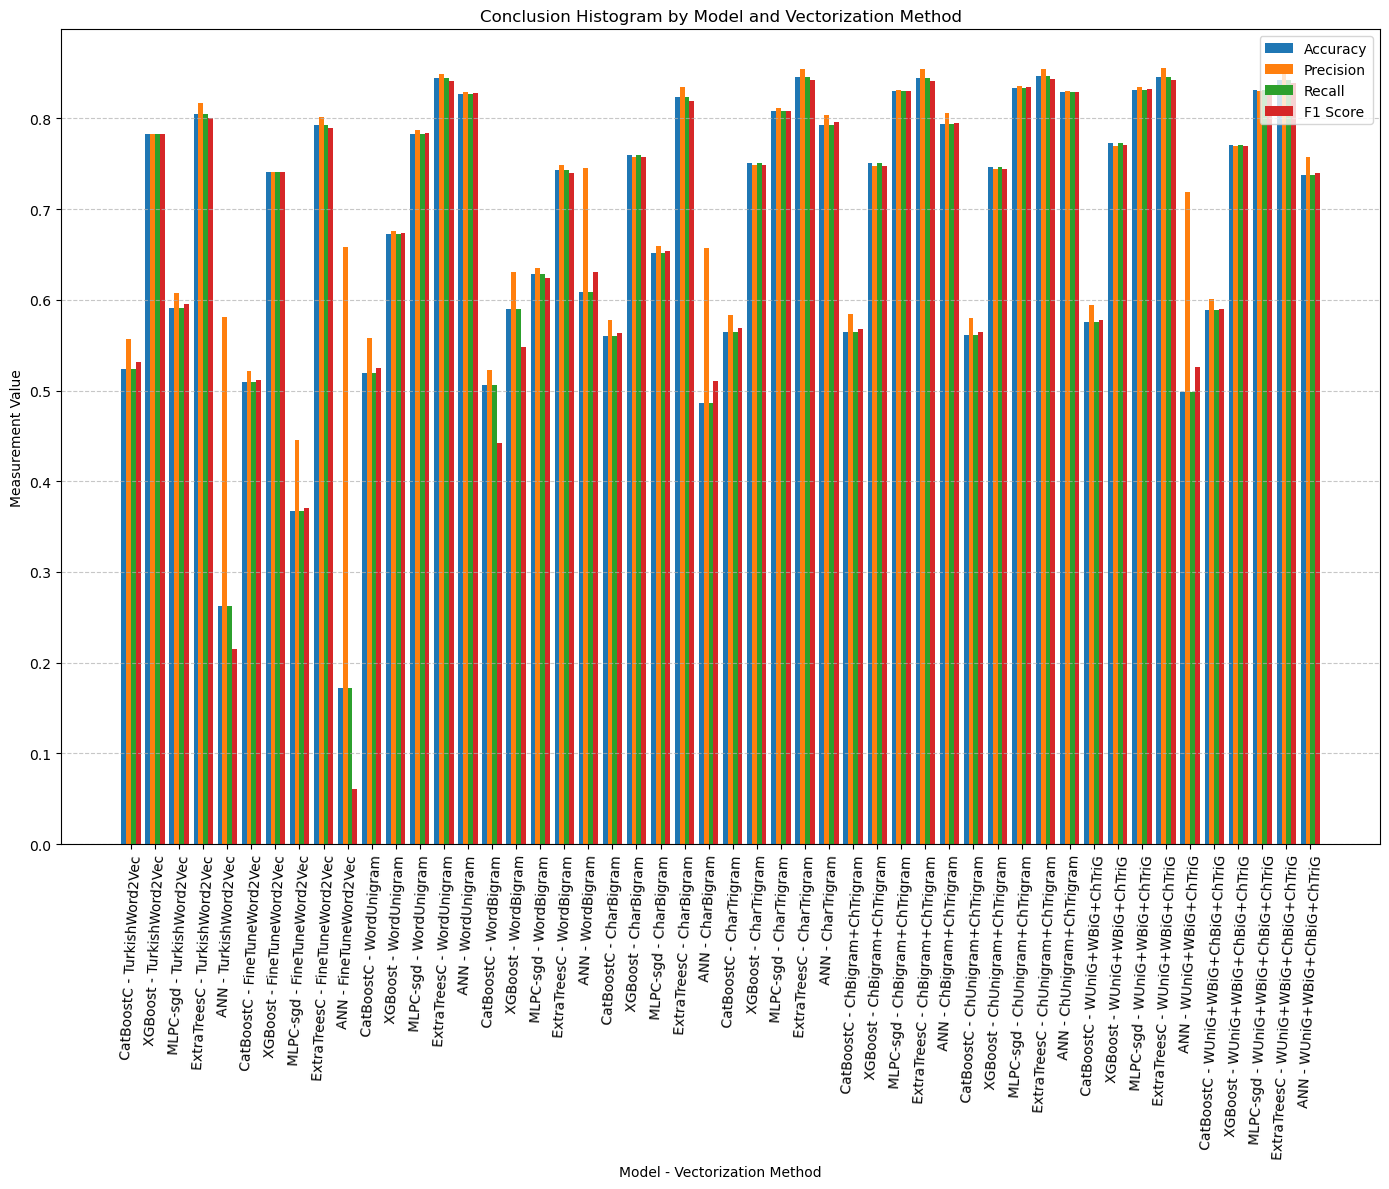

In [108]:
plot_conclusion(results_df, rotate_xticks=87)

In [113]:
results_df.to_csv("eval.csv", index=False)